In [1]:
#Import libraries
import time
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

#import doubletdetection
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import math

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=100)

/wynton/home/kimlab/hyang7/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
sample_list = pd.read_csv('../metadata/10x_bladder_blood_CD8_metadata.csv', sep = ',')
sample_list

filename        sample  \
0     170427_D00328_0646_AHKKLWBCXY_analysis/0501CD8    atezo2_pre   
1     170427_D00328_0646_AHKKLWBCXY_analysis/0503CD8   atezo2_post   
2     170427_D00328_0647_BHKNYWBCXY_analysis/0701CD8    atezo3_pre   
3     170427_D00328_0647_BHKNYWBCXY_analysis/0704CD8   atezo3_post   
4     170428_D00108_0706_BHJHMNBCXY_analysis/0802CD8    atezo4_pre   
5     170428_D00108_0706_BHJHMNBCXY_analysis/0804CD8   atezo4_post   
6               170914_D00328_0694_BHMJ5CBCXY/1201P8    atezo5_pre   
7      170914_D00328_0693_AHMHW5BCXY/1203P8_0801_693  atezo5_post2   
8   170427_D00108_0704_BHLFKYBCXY_analysis/BLAD02CD8       s1blood   
9   170428_D00108_0705_AHJHKWBCXY_analysis/BLAD03CD8       s2blood   
10  170428_D00108_0705_AHJHKWBCXY_analysis/BLAD05CD8       s3blood   
11     170915_D00328_0695_AHMH2YBCXY/H238P8_0720_695       h1blood   
12          170913_D00328_0692_BHMFHVBCXY/H238P8_692       h2blood   
13     170914_D00328_0693_AHMHW5BCXY/H238P8_0801_693       h3blood   

              pop treatment tissue patient comp  
0    a2_pre_blood       pre  blood      a2  CD8  
1   a2_post_blood     atezo  blood      a2  CD8  
2    a3_pre_blood       pre  blood      a3  CD8  
3   a3_post_blood     atezo  blood      a3  CD8  
4    a4_pre_blood       pre  blood      a4  CD8  
5   a4_post_blood     atezo  blood      a4  CD8  
6    a5_pre_blood       pre  blood      a5  CD8  
7   a5_post_blood     atezo  blood      a5  CD8  
8         s1blood       soc  blood      s1  CD8  
9         s2blood       soc  blood      s2  CD8  
10        s3blood       soc  blood      s3  CD8  
11        h1blood   healthy  blood      h1  CD8  
12        h2blood   healthy  blood      h2  CD8  
13        h3blood   healthy  blood      h3  CD8

In [3]:
RNA_files = np.array(sample_list['filename'])
RNA_files

array(['170427_D00328_0646_AHKKLWBCXY_analysis/0501CD8',
       '170427_D00328_0646_AHKKLWBCXY_analysis/0503CD8',
       '170427_D00328_0647_BHKNYWBCXY_analysis/0701CD8',
       '170427_D00328_0647_BHKNYWBCXY_analysis/0704CD8',
       '170428_D00108_0706_BHJHMNBCXY_analysis/0802CD8',
       '170428_D00108_0706_BHJHMNBCXY_analysis/0804CD8',
       '170914_D00328_0694_BHMJ5CBCXY/1201P8',
       '170914_D00328_0693_AHMHW5BCXY/1203P8_0801_693',
       '170427_D00108_0704_BHLFKYBCXY_analysis/BLAD02CD8',
       '170428_D00108_0705_AHJHKWBCXY_analysis/BLAD03CD8',
       '170428_D00108_0705_AHJHKWBCXY_analysis/BLAD05CD8',
       '170915_D00328_0695_AHMH2YBCXY/H238P8_0720_695',
       '170913_D00328_0692_BHMFHVBCXY/H238P8_692',
       '170914_D00328_0693_AHMHW5BCXY/H238P8_0801_693'], dtype=object)

In [18]:
#Load 10x data
#Create directories where cache folder will live
#!mkdir /ye/yelabstore3/PCI/005_production/analysis
#!mkdir /ye/yelabstore3/PCI/005_production/analysis/preprocessing
#Set directory where cahce files will save
# os.chdir("/wynton/group/ye/emccarthy/EM/bladder_cancer/")

#Update all these inputs
#START
no_wells = sample_list.shape[0]

#RNA_files = np.array(sample_list['sample'])
patient = np.array(sample_list['patient'])
tissue = np.array(sample_list['tissue'])
treatment = np.array(sample_list['treatment'])
sample = np.array(sample_list['sample'])
comp = np.array(sample_list['comp'])


RNA_path_prefix = "/ye/yelabstore2/bladder_cancer/10xdata_for_backup/"
RNA_path_suffix = "/outs/filtered_gene_bc_matrices/hg19/"
#END

#Initialize list to store adata objects
RNA_adata = [None] * no_wells


#Initialize dataframe to store cell counts
#height = 6
height = 1
width = no_wells
cell_count_df = pd.DataFrame(0, index=range(height), columns=range(width))
cell_count_df.rename(index={0:'Cells'}, inplace=True)
#Rename the columns
cell_count_df.columns = RNA_files


In [23]:
for i in range(no_wells):
    start = time.time()
    
    well = RNA_files[i]
    print(well)
    #Load RNA adata
    path = RNA_path_prefix + RNA_files[i] + RNA_path_suffix
#     RNA_adata[i] = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    RNA_adata[i] = sc.read_10x_mtx(path, var_names='gene_symbols', cache=False)
    print("Loaded RNA")
    
    
    
    print("Added singlet info")
    cell_count_df[well] = [RNA_adata[i].shape[0]]
    
    print("Add cell annotations")

    RNA_adata[i].obs['patient'] = [patient[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['tissue'] = [tissue[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['treatment'] = [treatment[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['sample'] = [sample[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['comp'] = [comp[i]]*RNA_adata[i].shape[0]
    
    end = time.time()
    print(end-start, "sec")


170427_D00328_0646_AHKKLWBCXY_analysis/0501CD8
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
3.5234053134918213 sec
170427_D00328_0646_AHKKLWBCXY_analysis/0503CD8
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
6.346471309661865 sec
170427_D00328_0647_BHKNYWBCXY_analysis/0701CD8
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
1.0915424823760986 sec
170427_D00328_0647_BHKNYWBCXY_analysis/0704CD8
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
6.470611572265625 sec
170428_D00108_0706_BHJHMNBCXY_analysis/0802CD8
--> This might be v

In [24]:
cell_count_df.T

Cells
170427_D00328_0646_AHKKLWBCXY_analysis/0501CD8     2943
170427_D00328_0646_AHKKLWBCXY_analysis/0503CD8     4089
170427_D00328_0647_BHKNYWBCXY_analysis/0701CD8      735
170427_D00328_0647_BHKNYWBCXY_analysis/0704CD8     5696
170428_D00108_0706_BHJHMNBCXY_analysis/0802CD8     5479
170428_D00108_0706_BHJHMNBCXY_analysis/0804CD8     4958
170914_D00328_0694_BHMJ5CBCXY/1201P8               3827
170914_D00328_0693_AHMHW5BCXY/1203P8_0801_693      2934
170427_D00108_0704_BHLFKYBCXY_analysis/BLAD02CD8   2815
170428_D00108_0705_AHJHKWBCXY_analysis/BLAD03CD8   4399
170428_D00108_0705_AHJHKWBCXY_analysis/BLAD05CD8   6263
170915_D00328_0695_AHMH2YBCXY/H238P8_0720_695      2341
170913_D00328_0692_BHMFHVBCXY/H238P8_692           2266
170914_D00328_0693_AHMHW5BCXY/H238P8_0801_693      2485

170427_D00328_0646_AHKKLWBCXY_analysis/0501CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


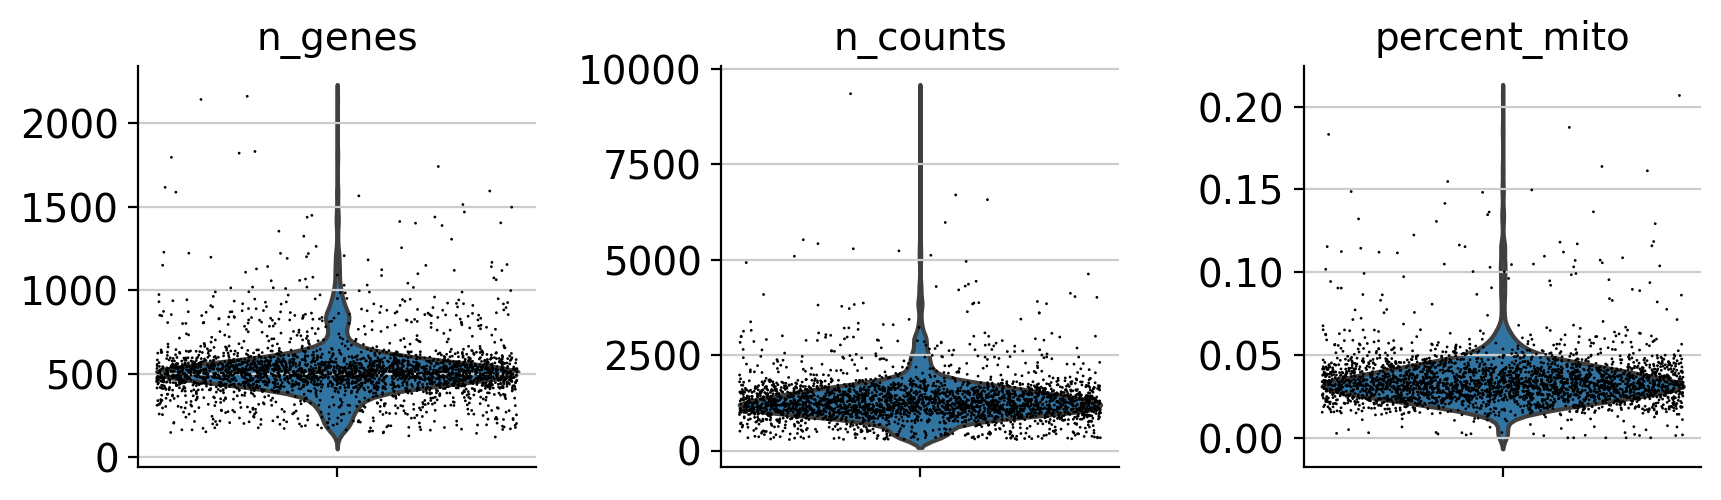

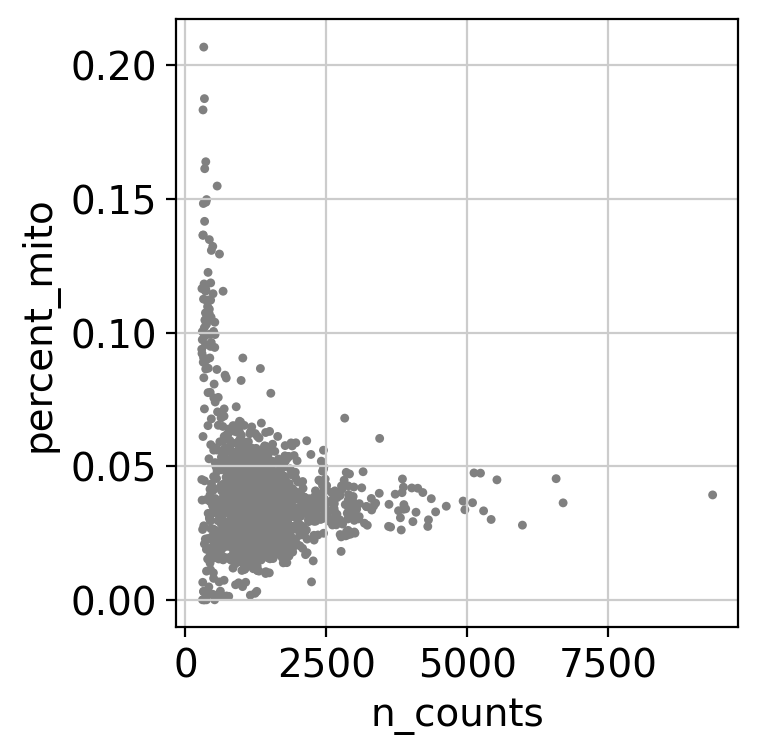

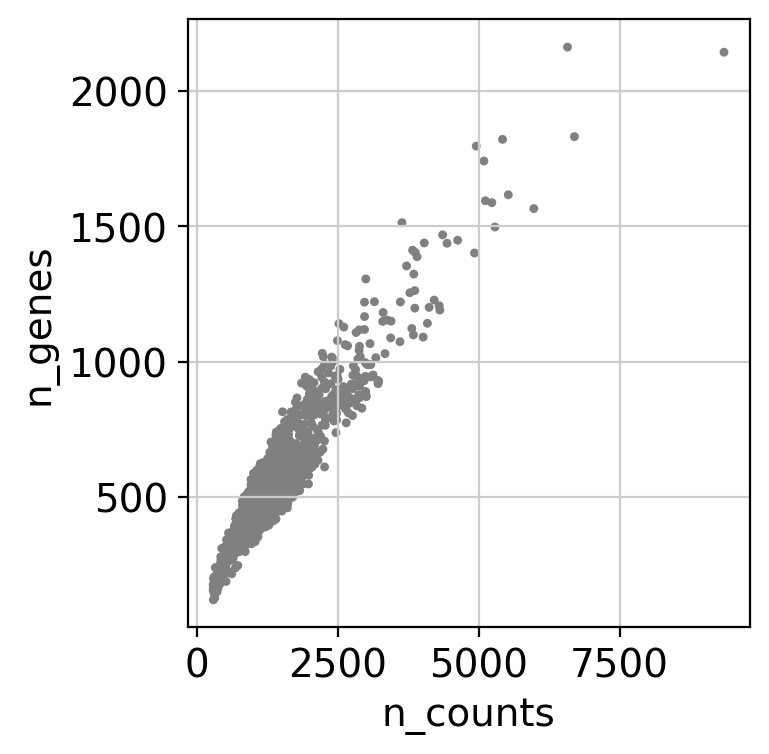

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170427_D00328_0646_AHKKLWBCXY_analysis/0503CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


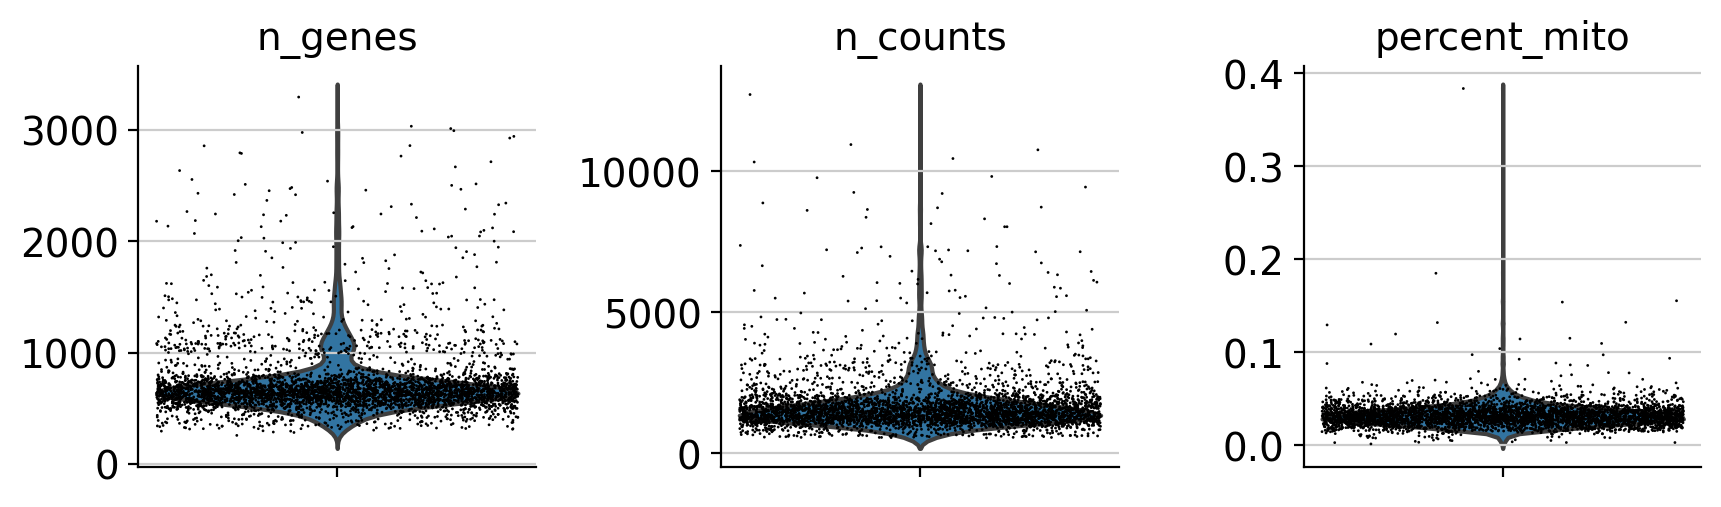

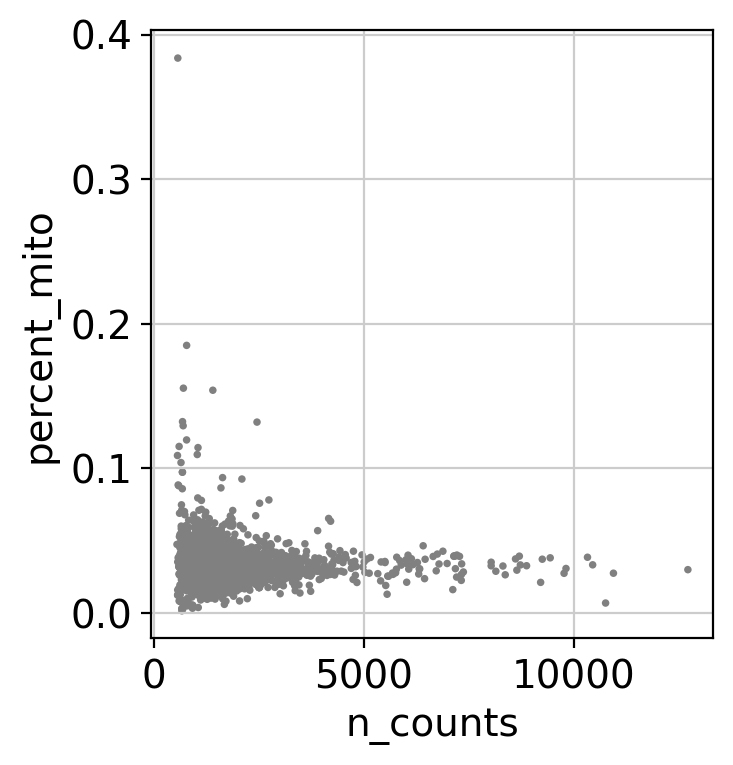

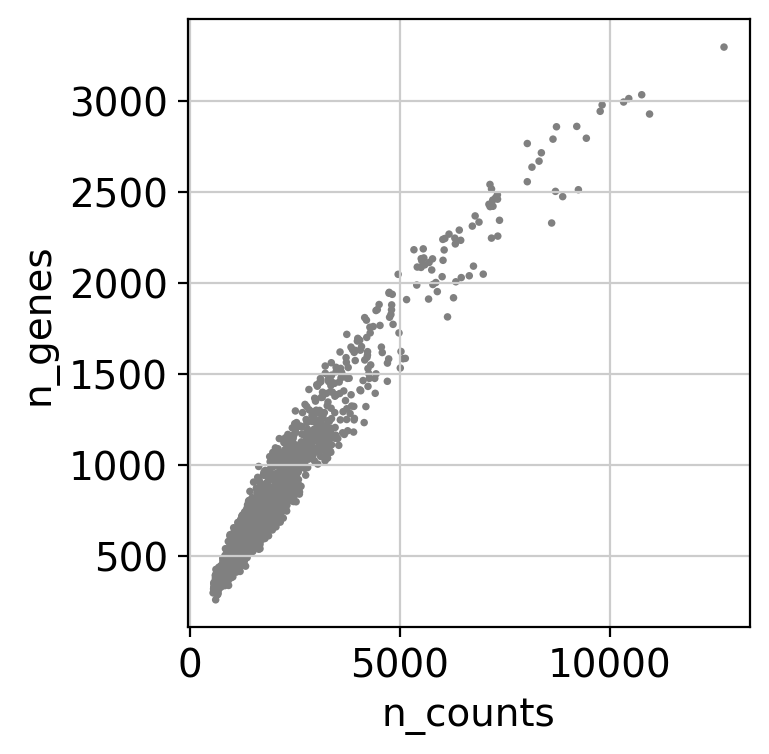

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170427_D00328_0647_BHKNYWBCXY_analysis/0701CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


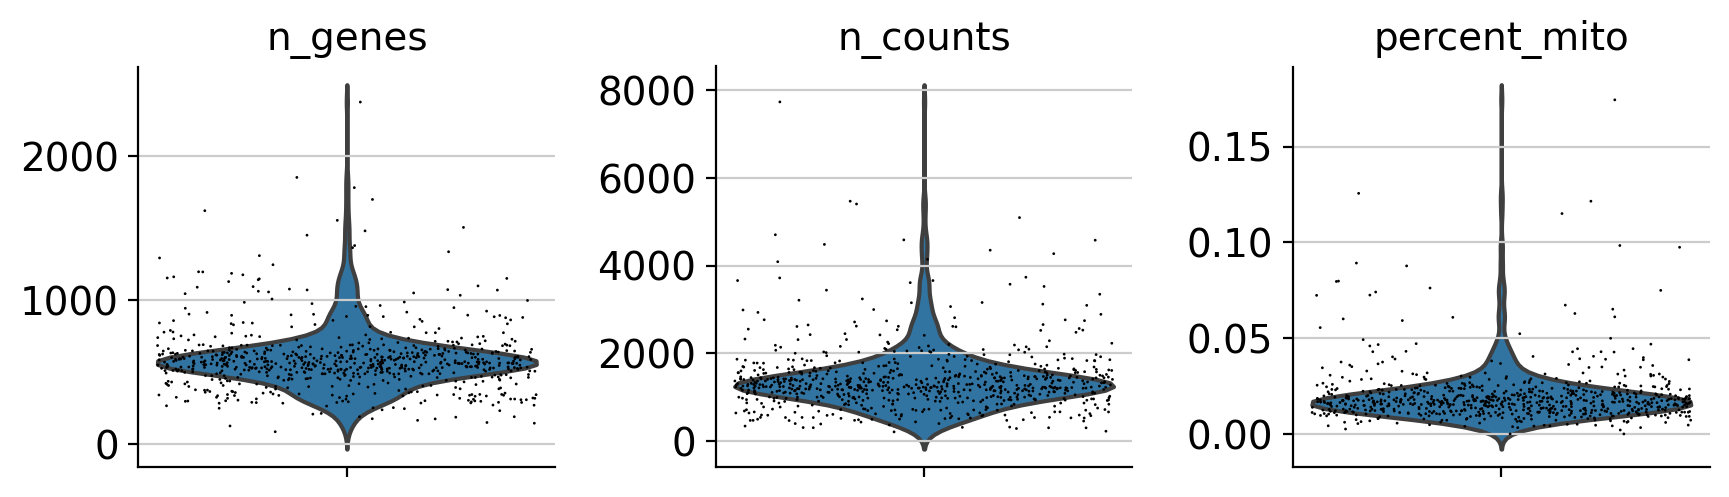

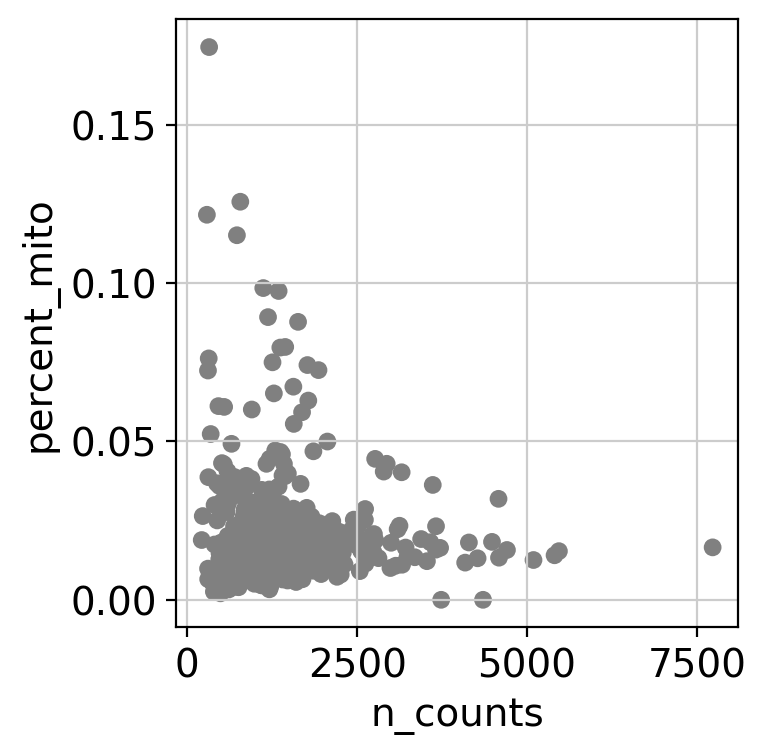

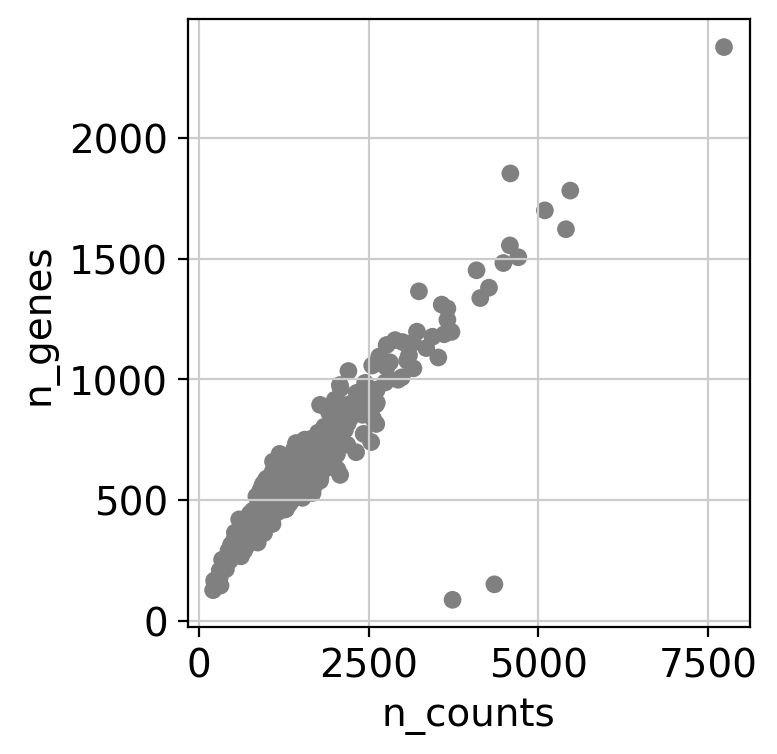

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170427_D00328_0647_BHKNYWBCXY_analysis/0704CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


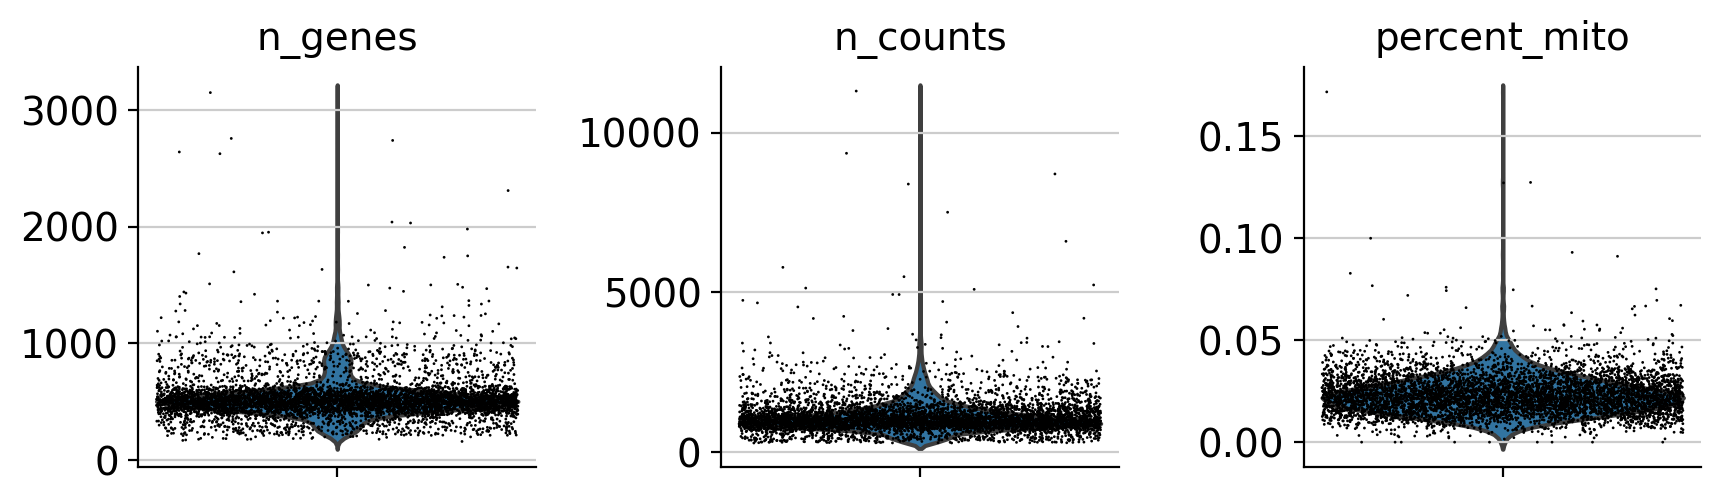

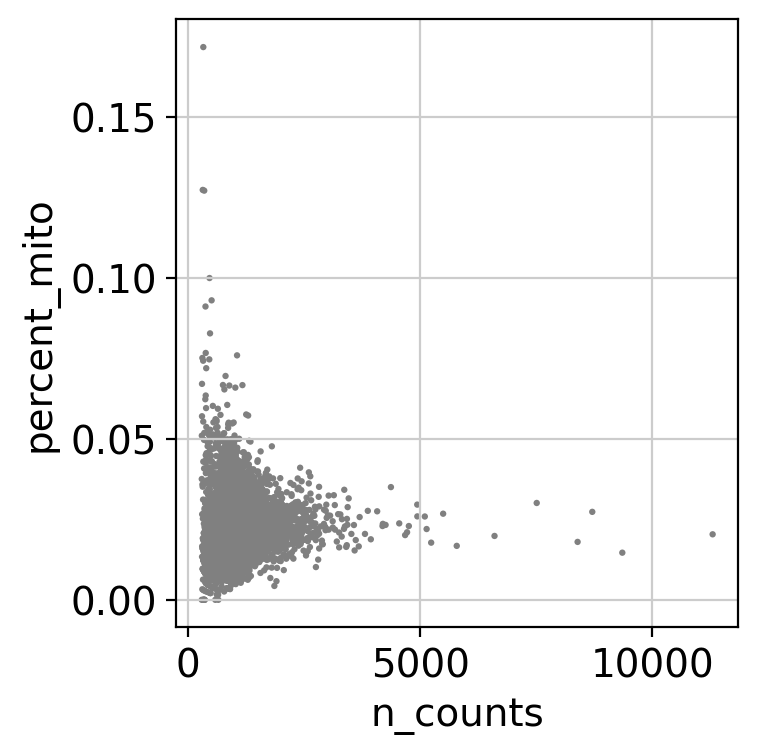

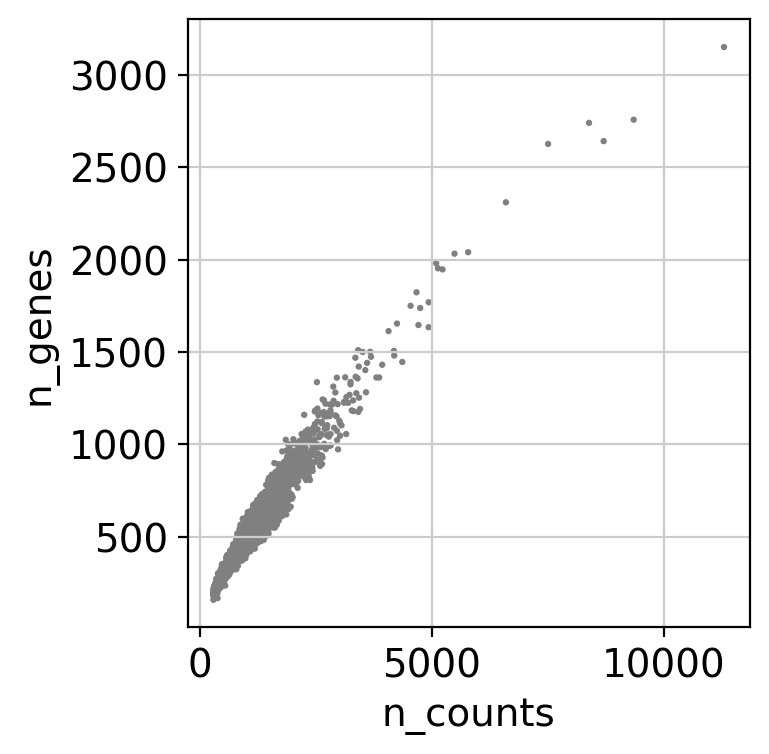

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170428_D00108_0706_BHJHMNBCXY_analysis/0802CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


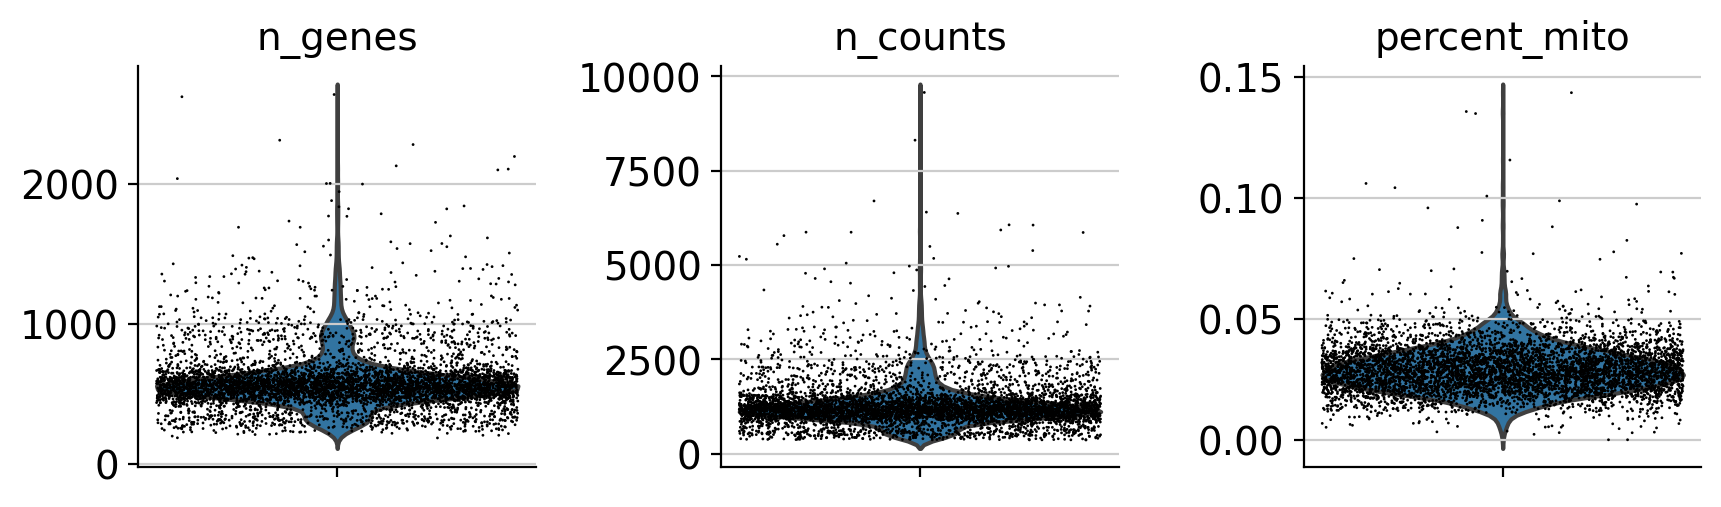

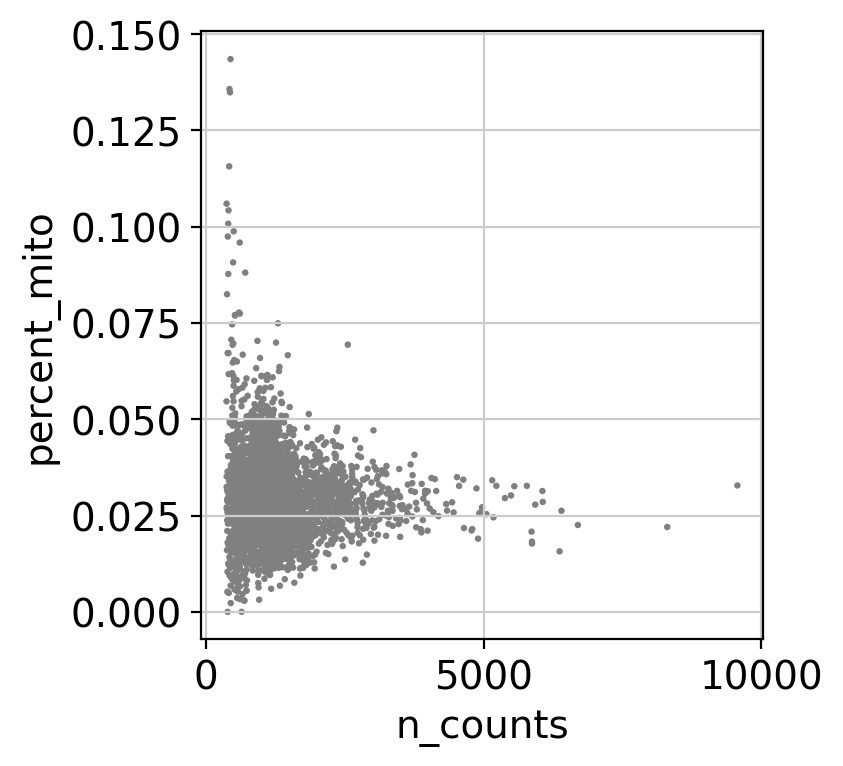

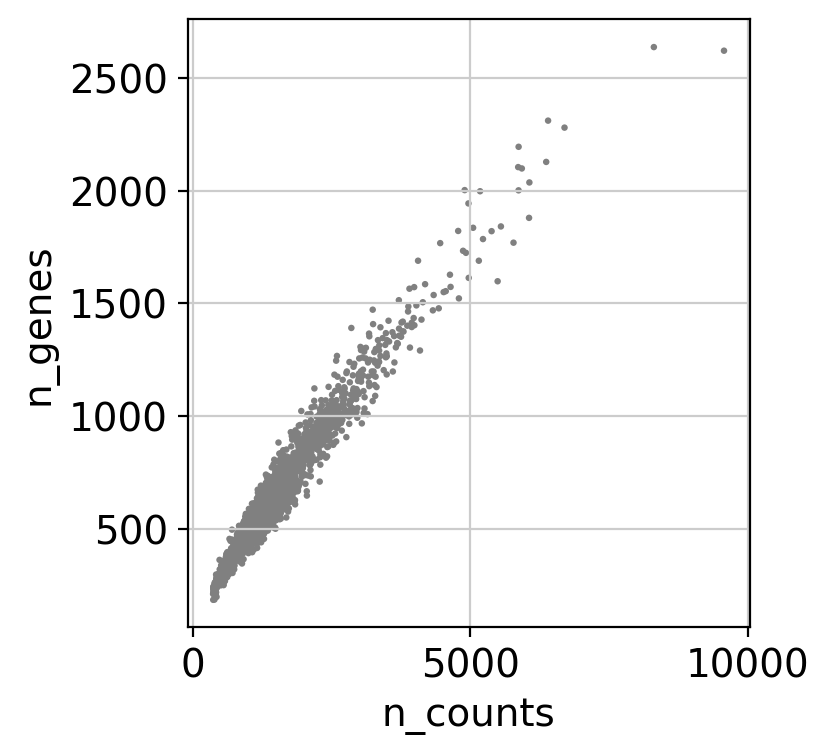

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170428_D00108_0706_BHJHMNBCXY_analysis/0804CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


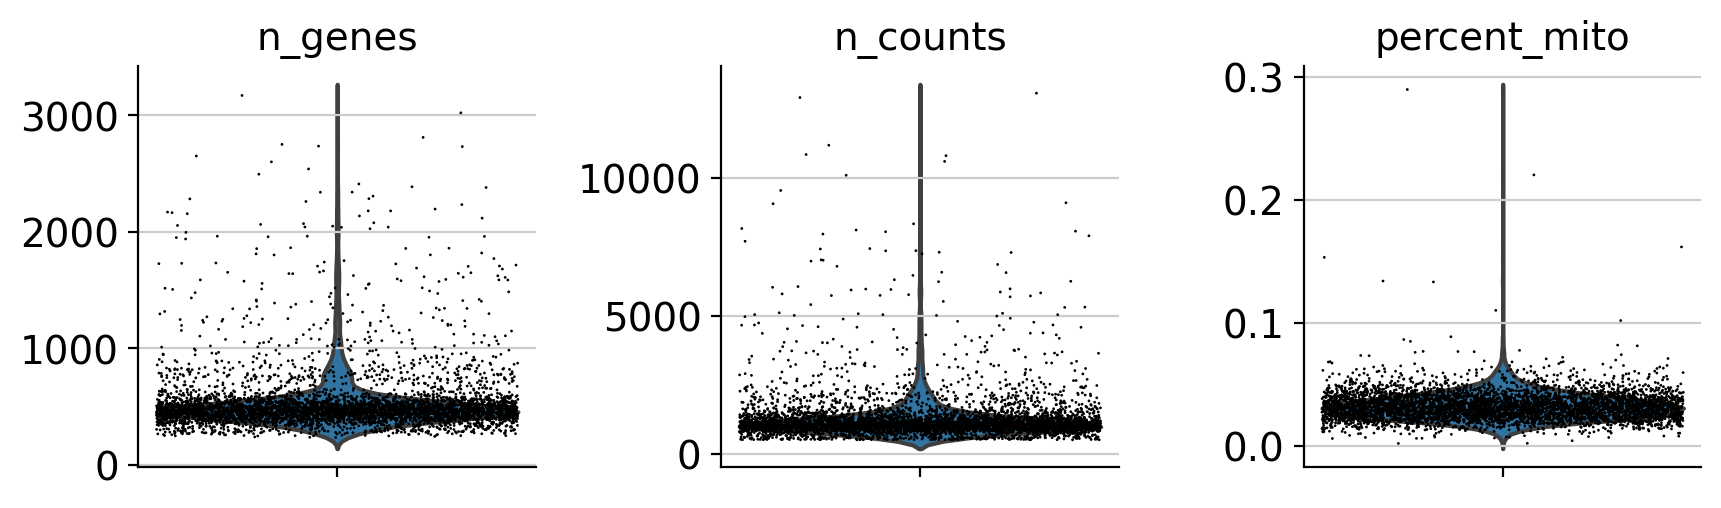

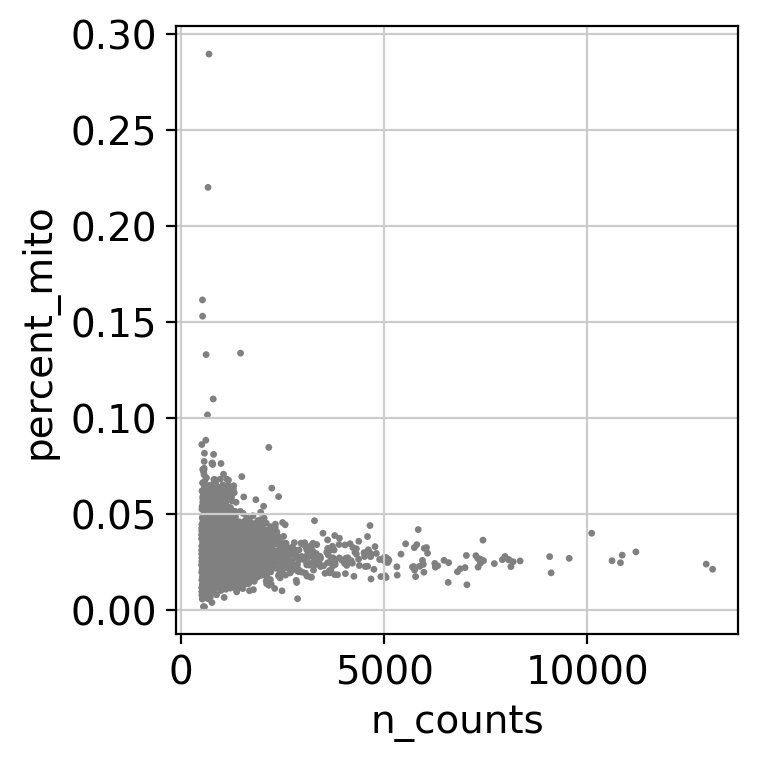

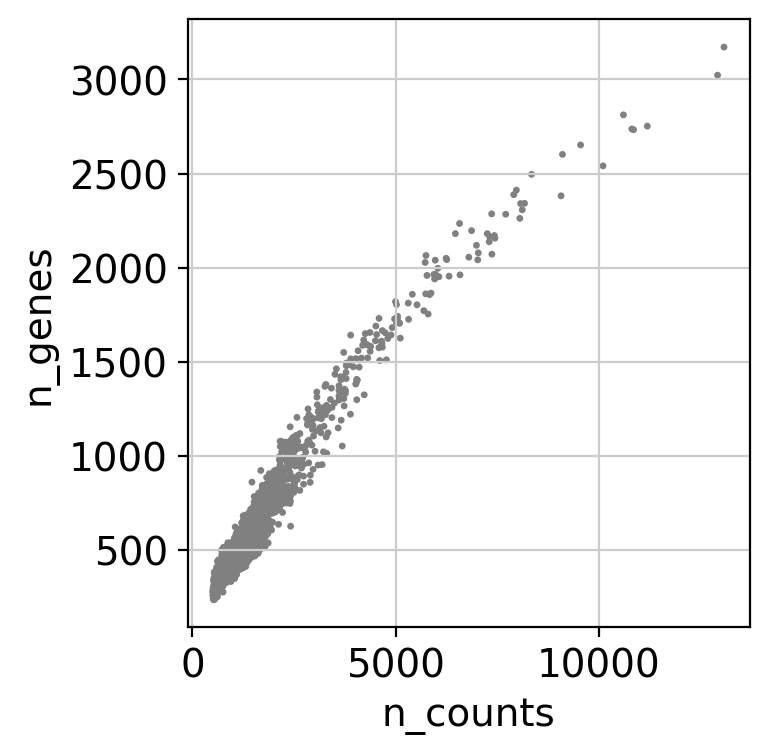

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170914_D00328_0694_BHMJ5CBCXY/1201P8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


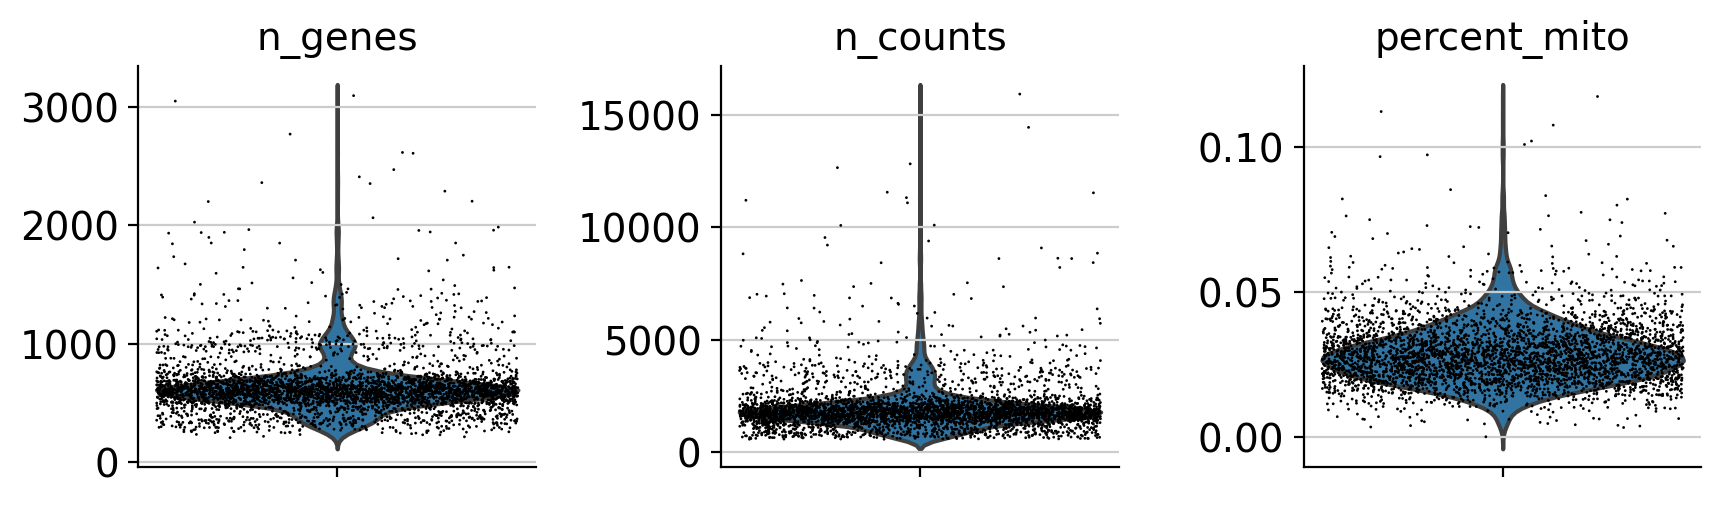

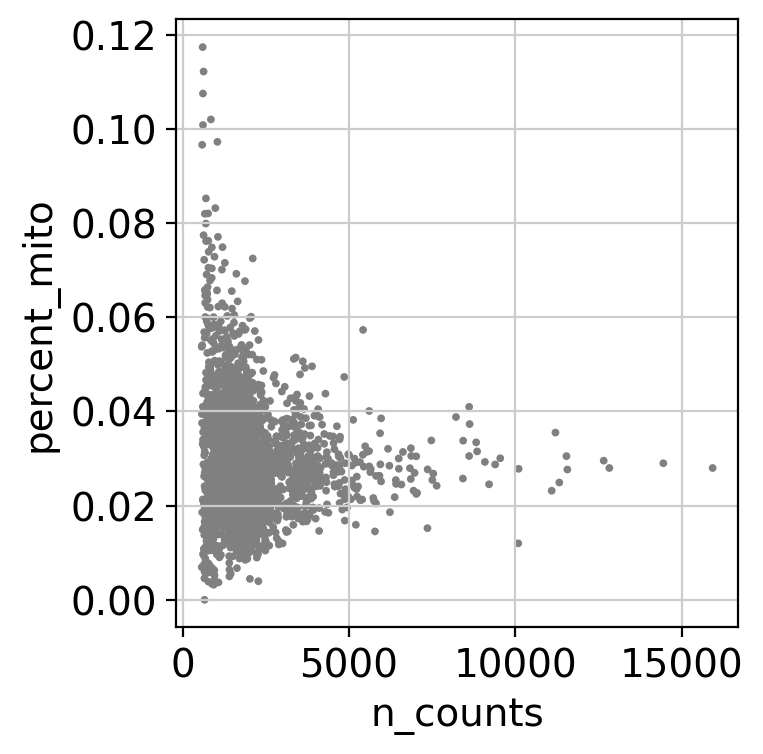

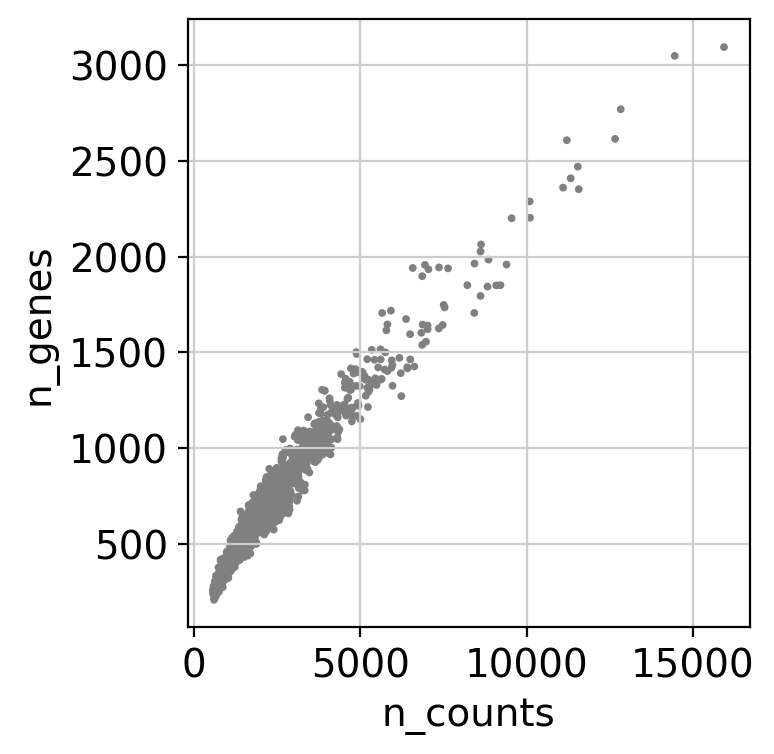

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170914_D00328_0693_AHMHW5BCXY/1203P8_0801_693
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


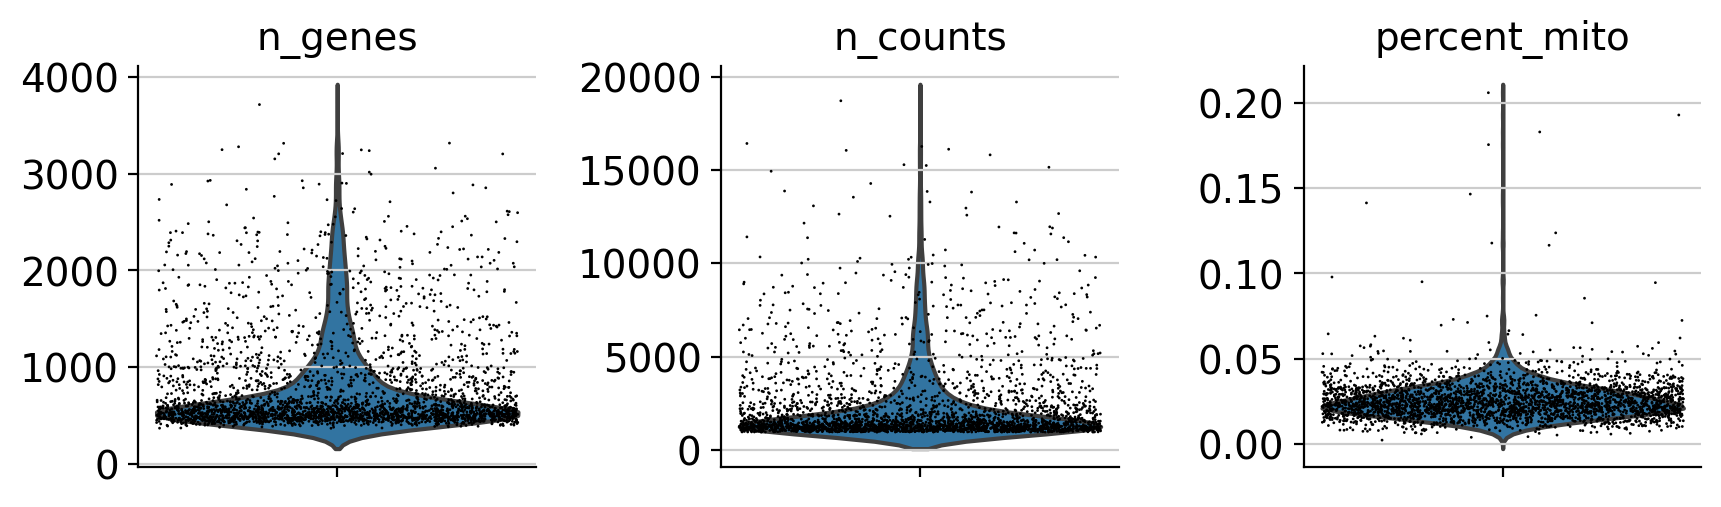

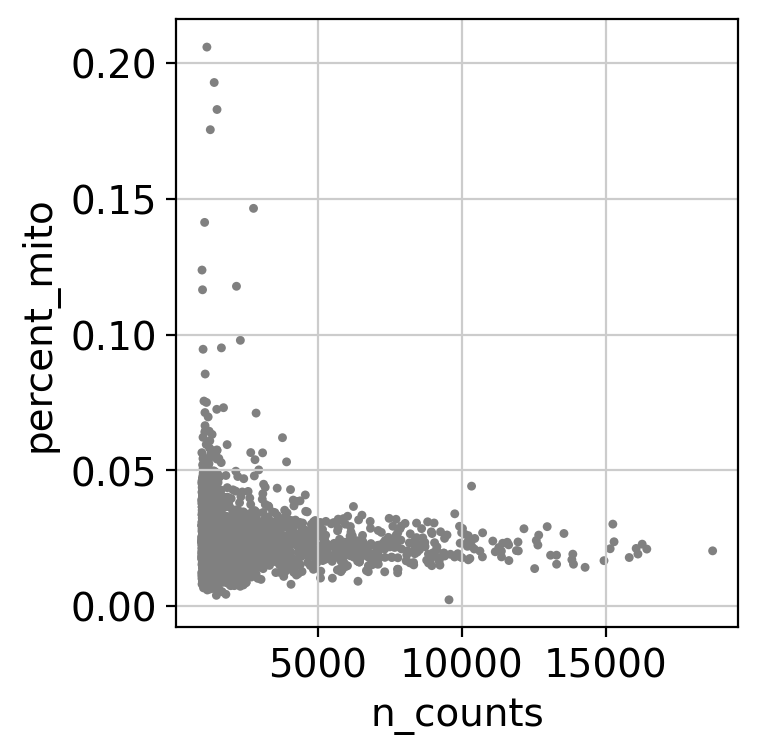

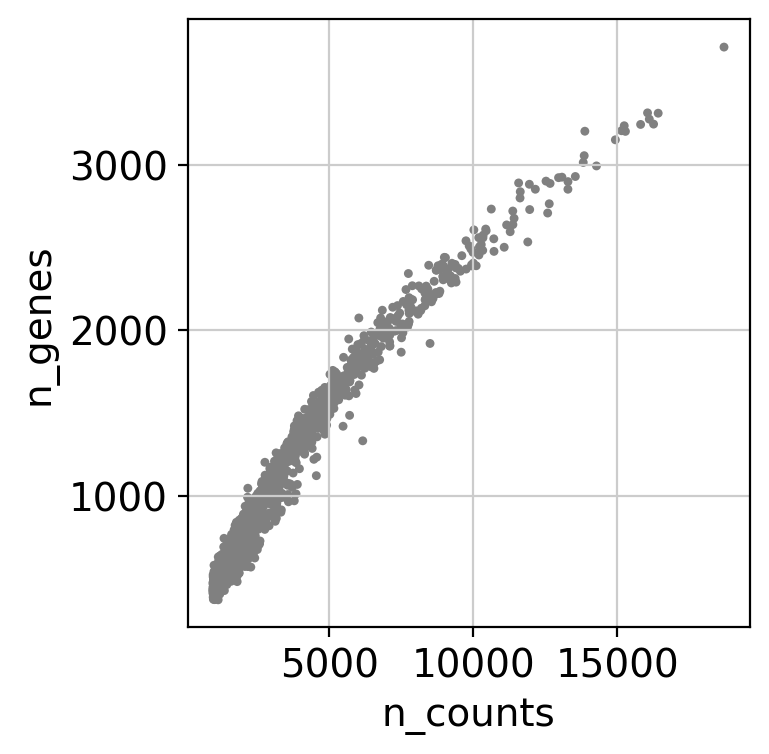

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170427_D00108_0704_BHLFKYBCXY_analysis/BLAD02CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


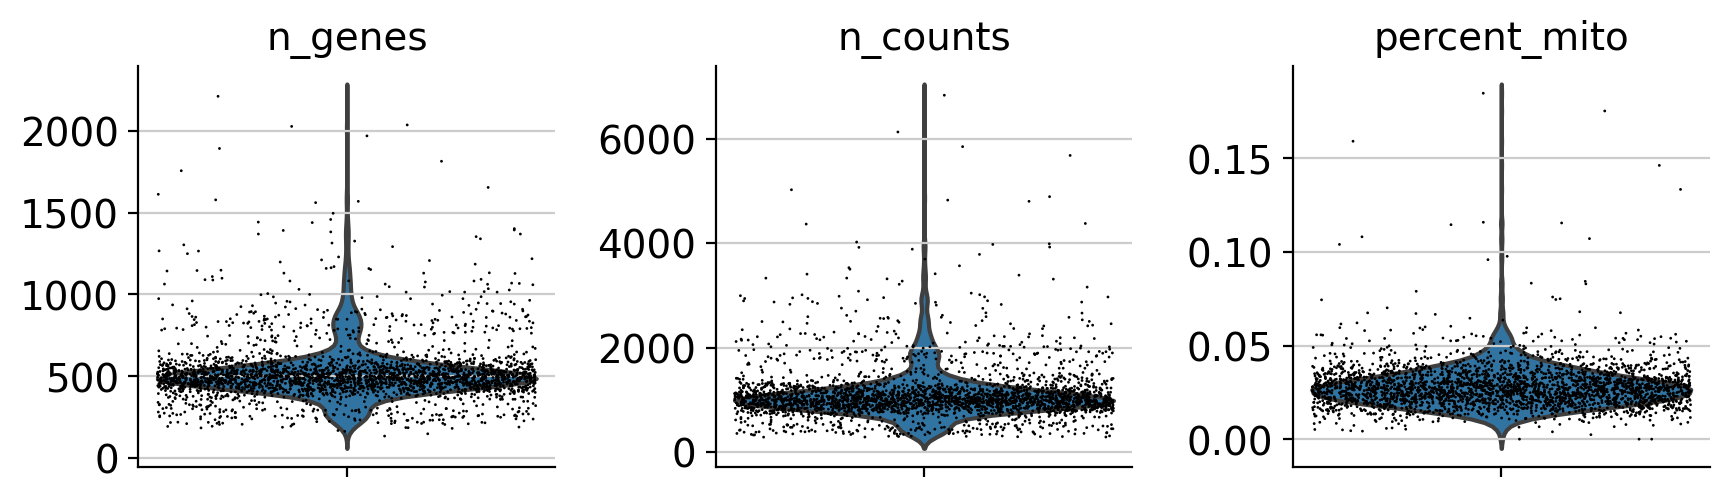

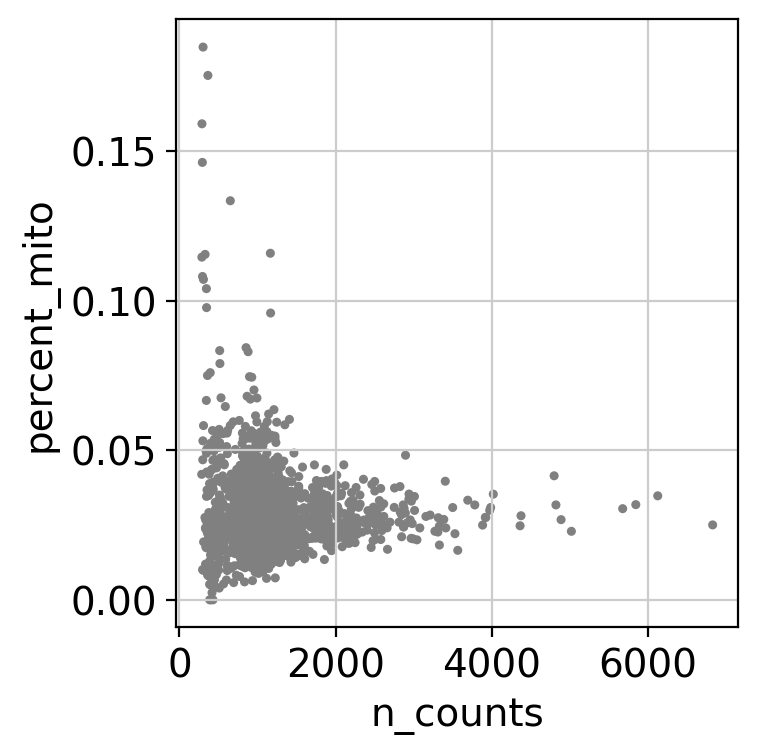

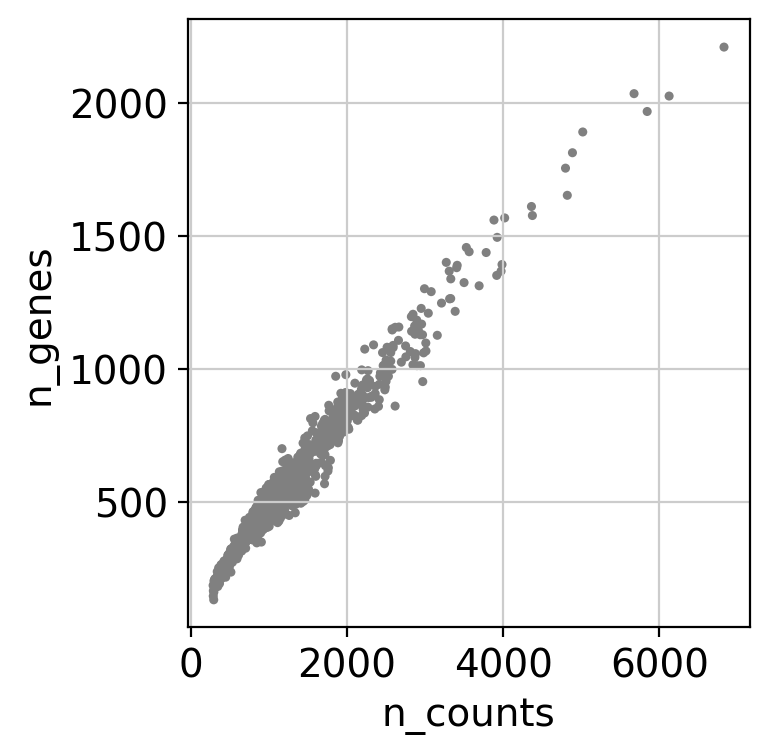

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170428_D00108_0705_AHJHKWBCXY_analysis/BLAD03CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


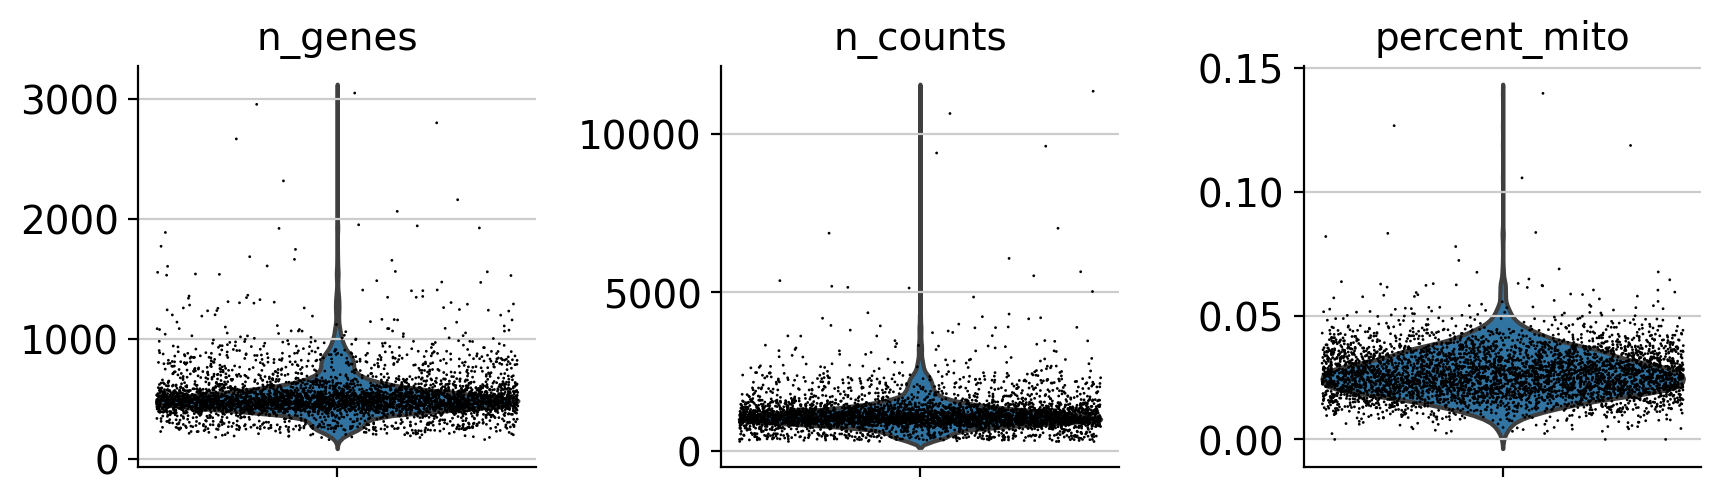

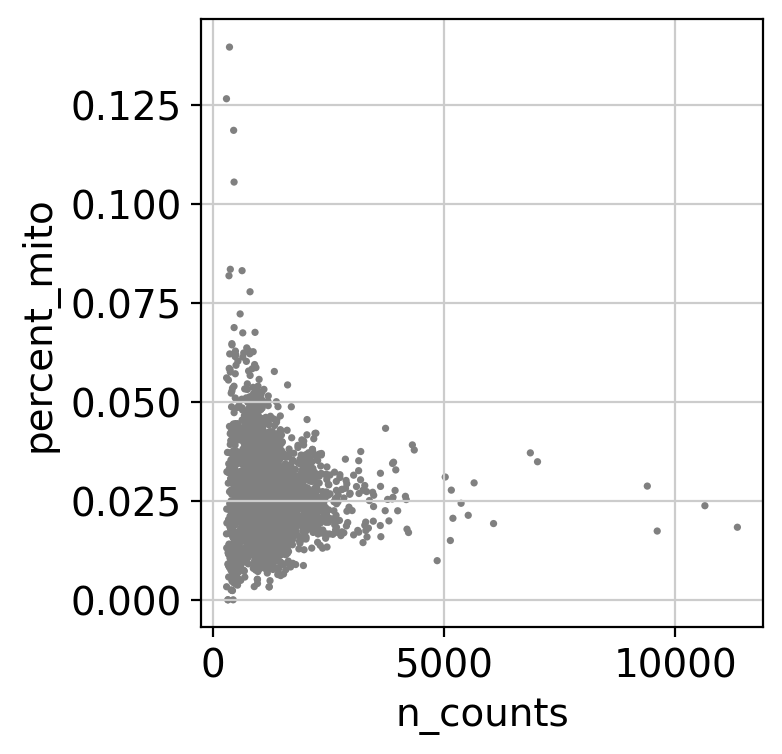

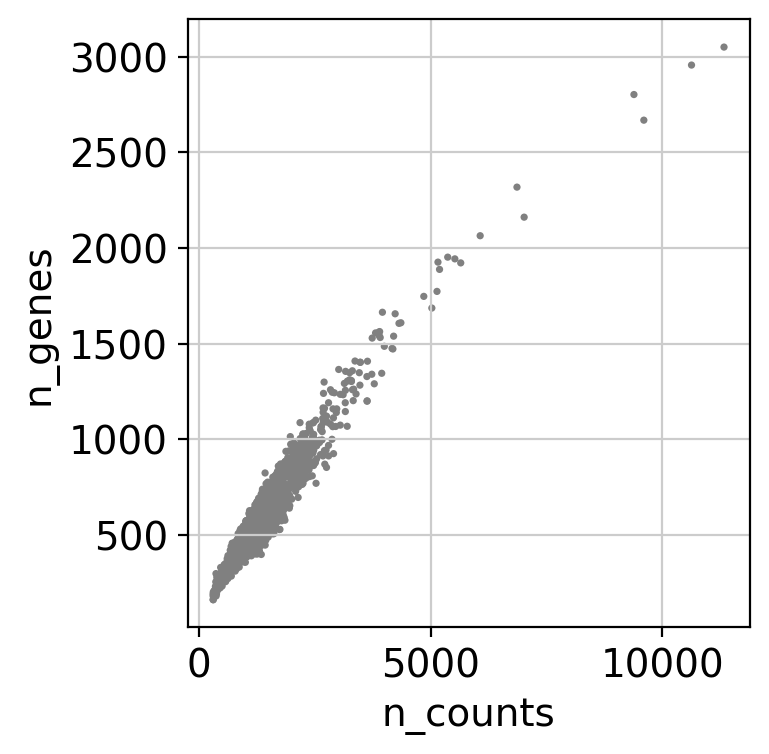

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170428_D00108_0705_AHJHKWBCXY_analysis/BLAD05CD8
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


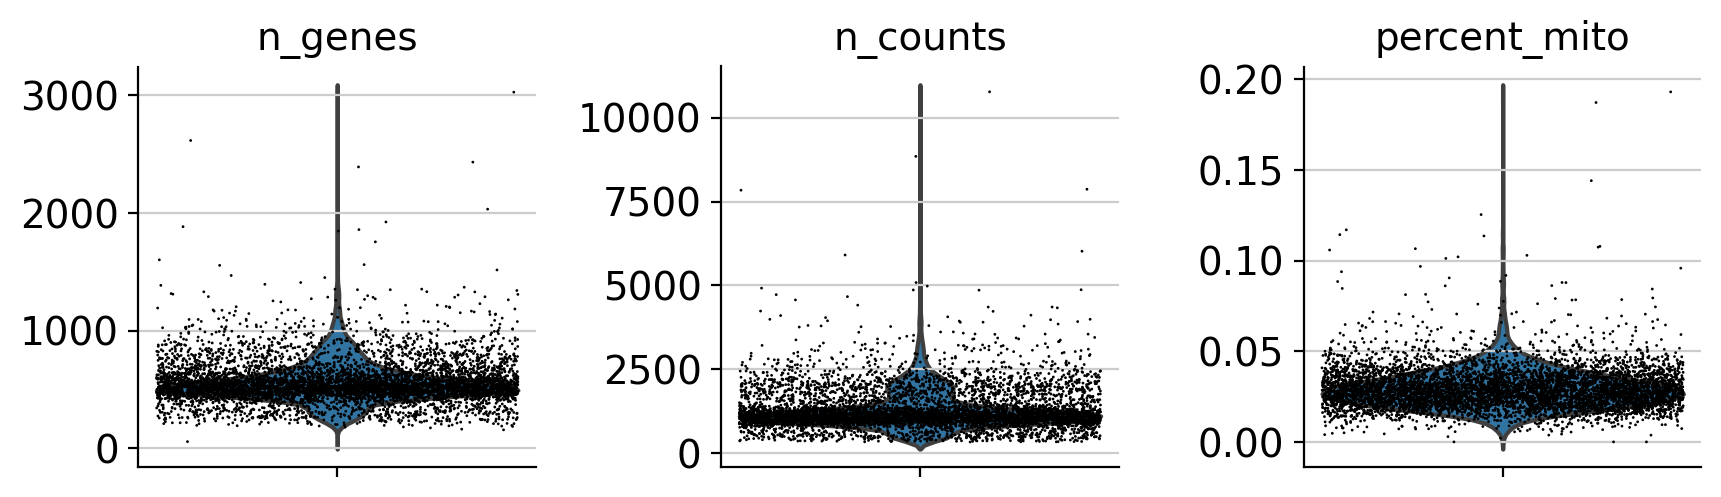

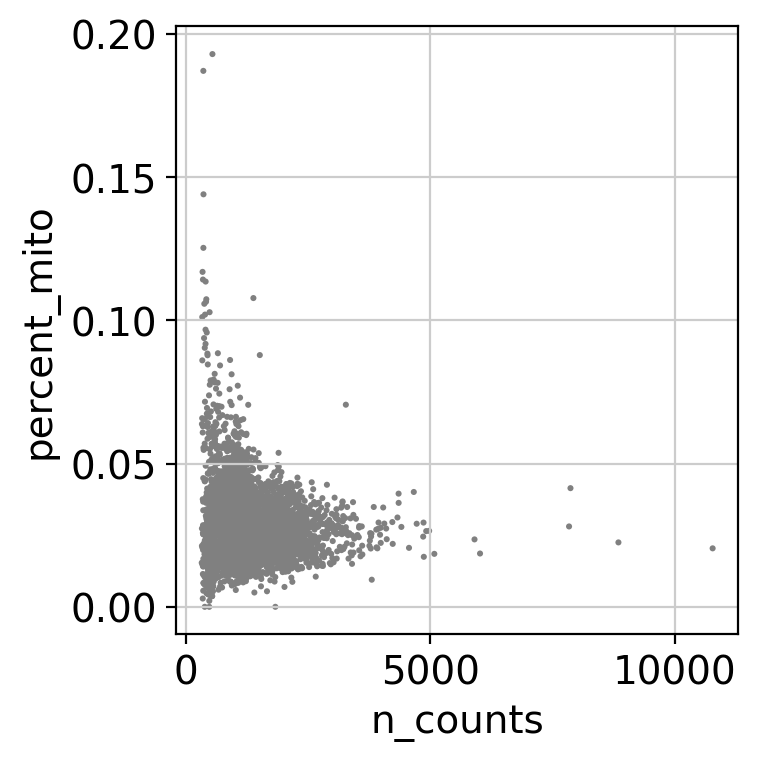

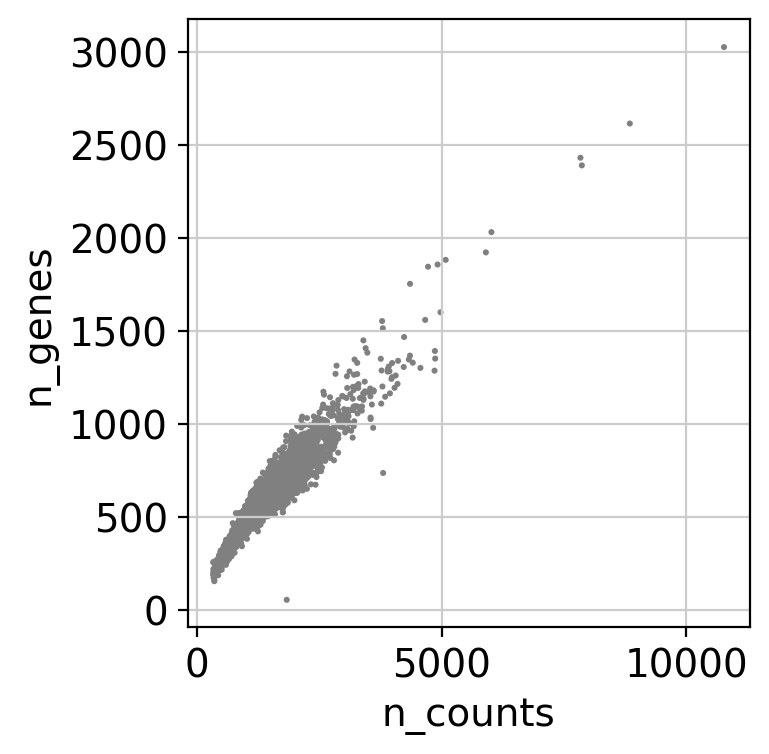

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170915_D00328_0695_AHMH2YBCXY/H238P8_0720_695
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


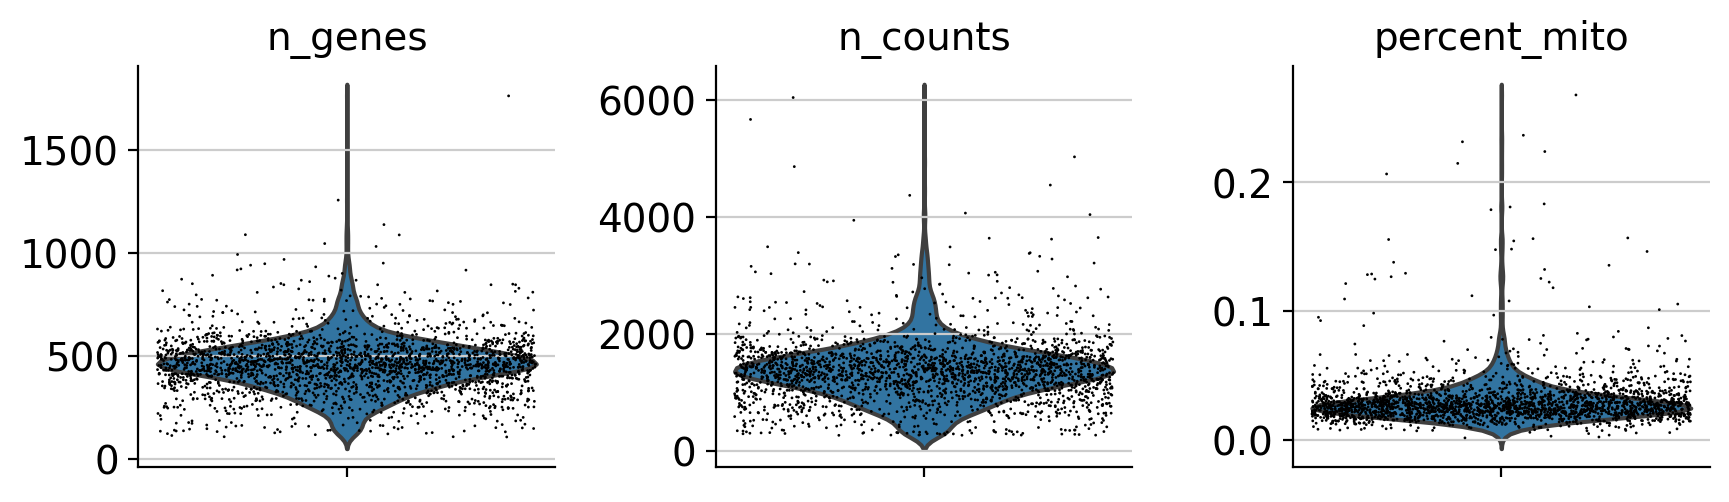

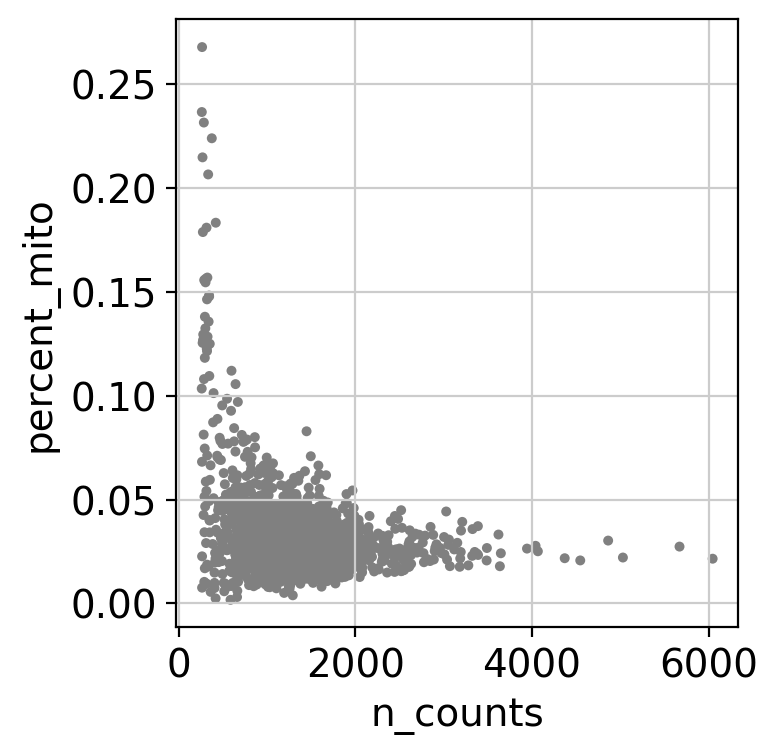

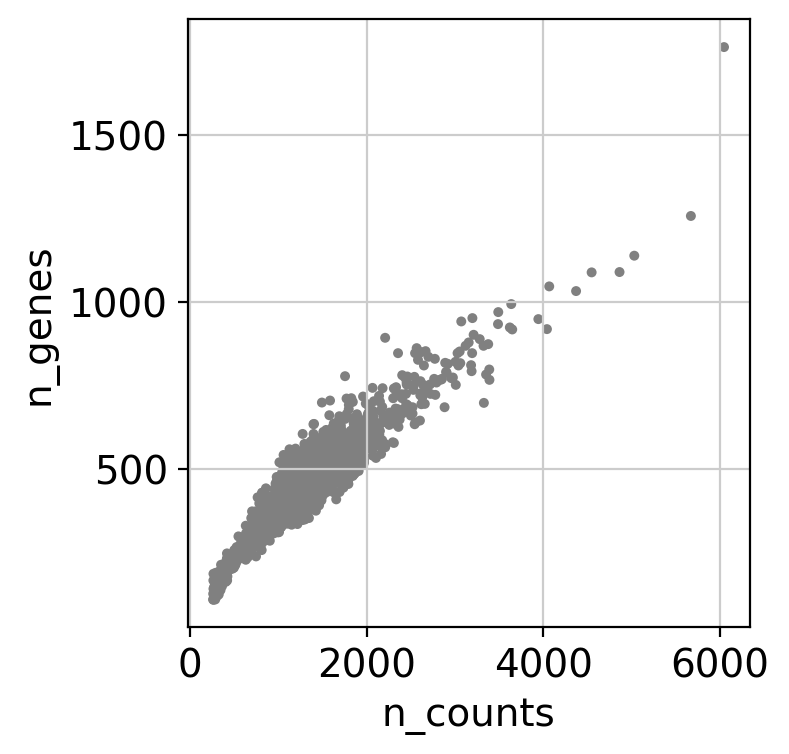

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170913_D00328_0692_BHMFHVBCXY/H238P8_692
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


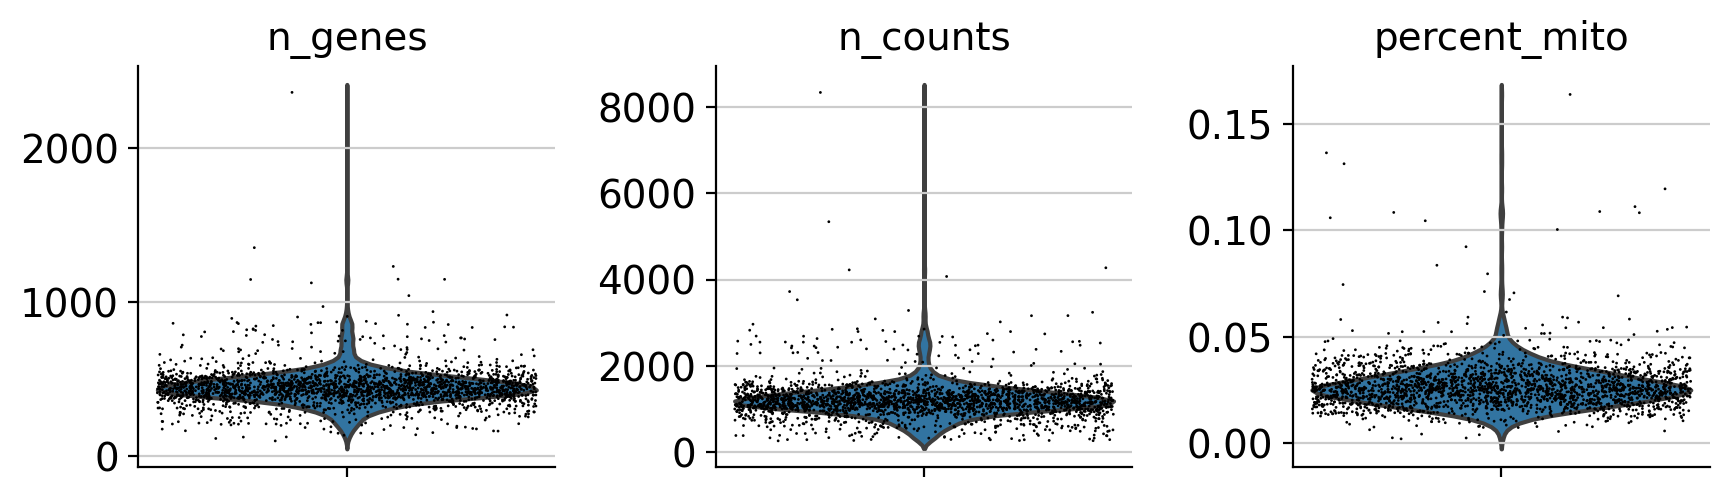

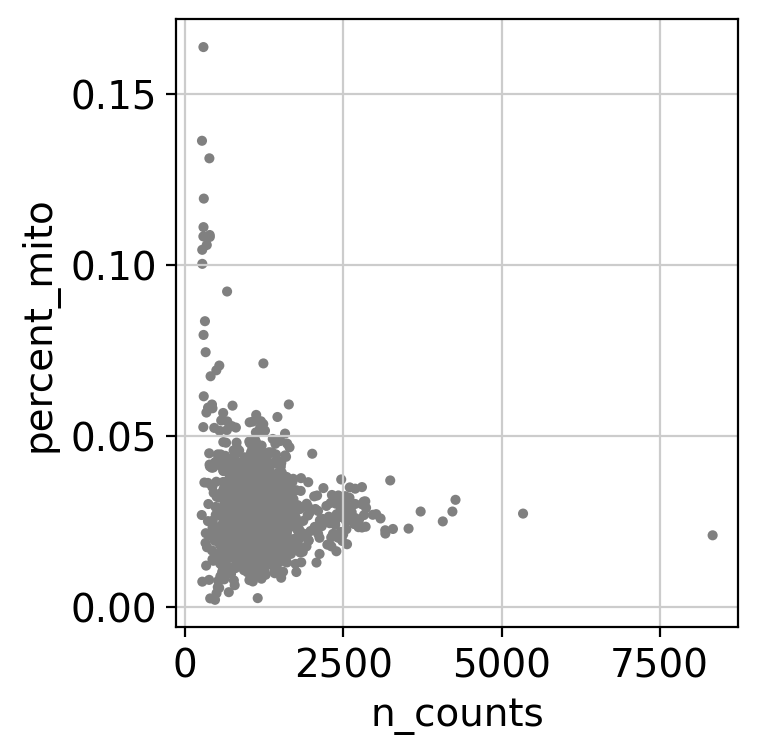

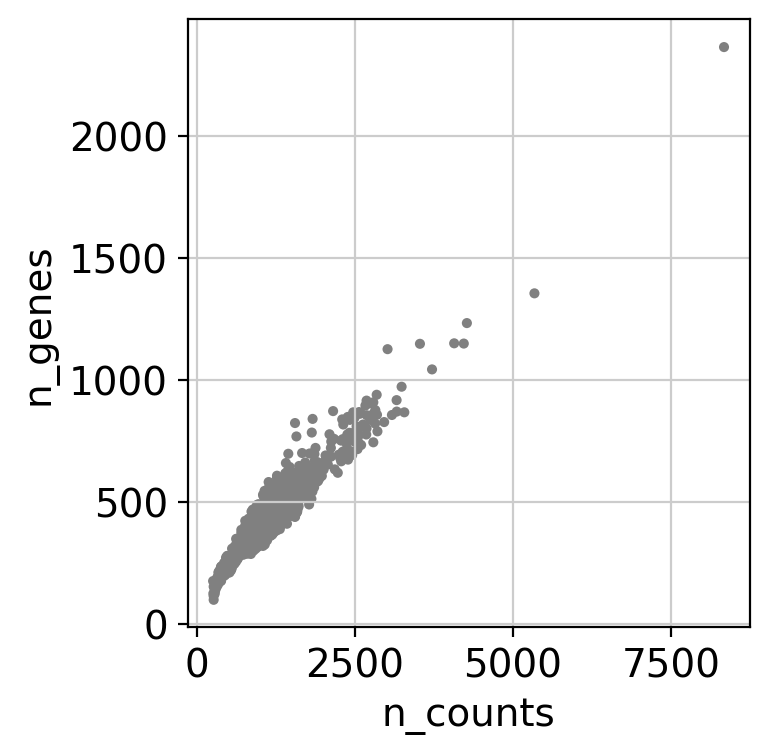

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170914_D00328_0693_AHMHW5BCXY/H238P8_0801_693
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


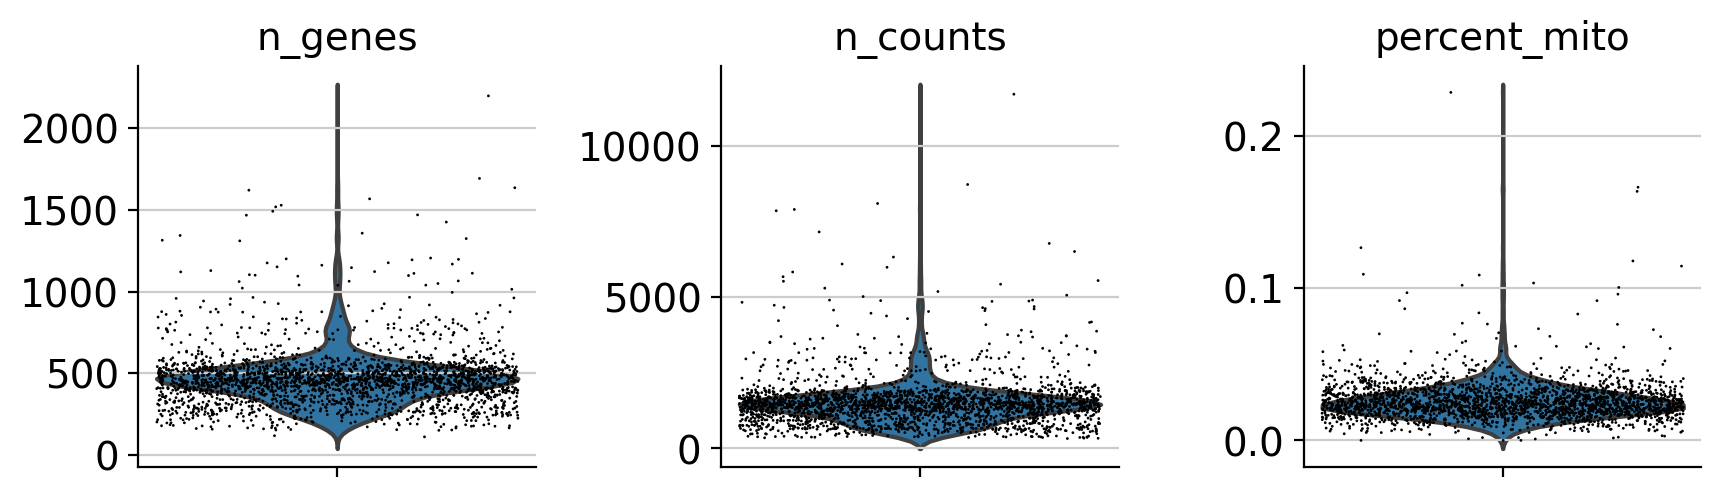

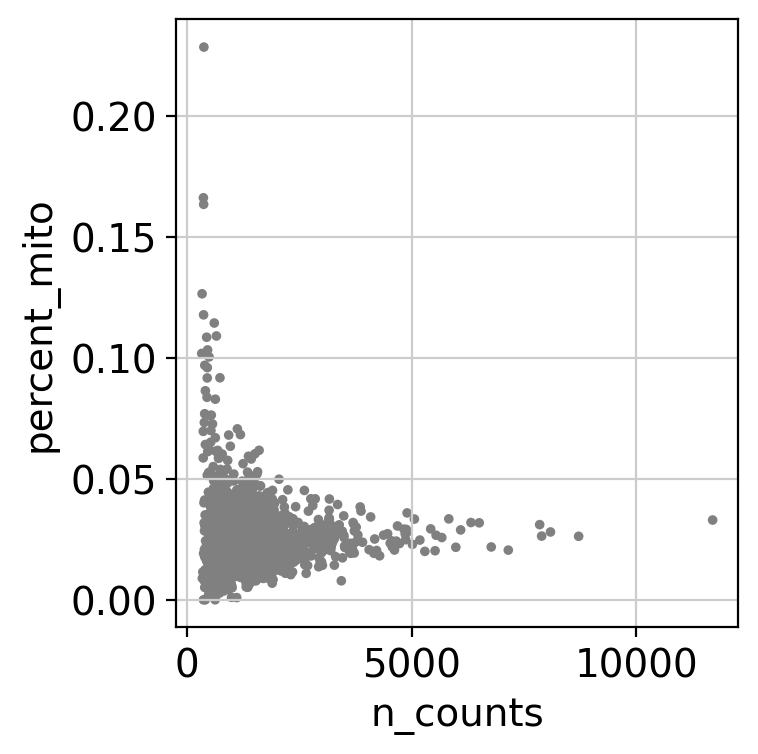

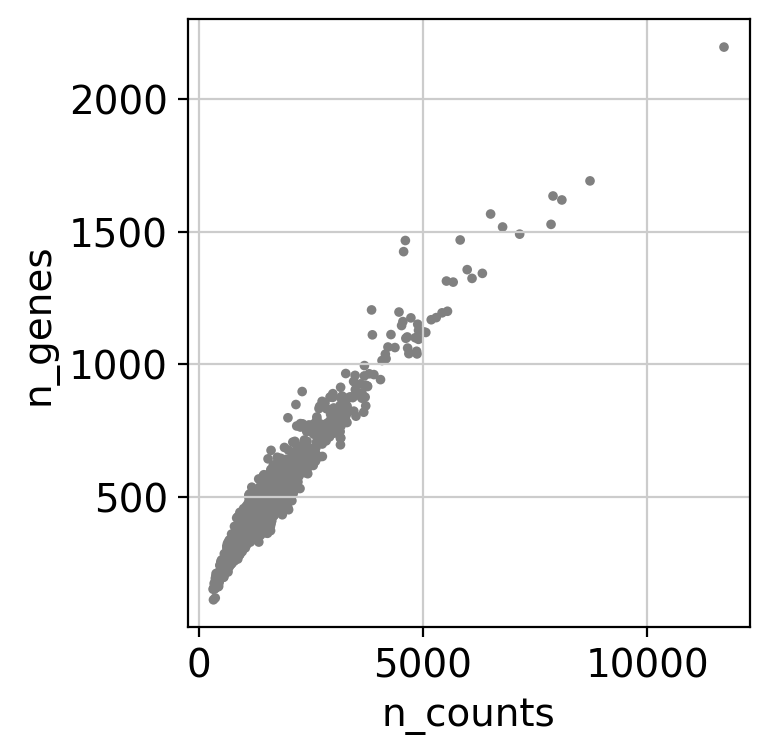

In [25]:
#Initialize dataframe to store cell counts
height = 4
width = no_wells

contamination_df = pd.DataFrame(0, index=range(height), columns=range(width))
contamination_df.rename(index={0:'Cells',1:'Platelets',2:'RBCs',3:'% cell with < 10% mito'}, inplace=True)
contamination_df.columns = RNA_files

for adata_index in range(len(RNA_adata)):
    adata = RNA_adata[adata_index]
    well = RNA_files[adata_index]
    print(well)
    #Remove platelets
    original_cell_no = adata.shape[0]
    
    print('Annotating platelet contamination and Megakaryocytes.')
    mat = csr_matrix(adata.X)
    mat = mat[:, adata.var_names.isin(['PF4'])].todense()

    platelets = adata[np.ravel(mat > 0)].obs.index
    no_platelets = len(platelets)
    
    platelet_info = [False] * original_cell_no
    
    index = 0
    
    for x in adata.obs.index:
        if x in platelets:
            platelet_info[index] = True
        index += 1
        
    adata.obs['platelet'] = platelet_info   
    print('Annotating RBCs')

    mat = csr_matrix(adata.X)
    mat = mat[:, adata.var_names.isin(['HBB'])].todense()
    
    RBCs = adata[np.ravel(mat > 1)].obs.index
    no_RBCs = len(RBCs)
    
    RBC_info = [False] * original_cell_no
    
    index = 0
    for x in adata.obs.index:
        if x in RBCs:
            RBC_info[index] = True
        index += 1

    adata.obs['RBC'] = RBC_info
    
    #Calculate quality metrics
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    #sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', percent_top=(50, 100, 200, 500), inplace=True)
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata.obs['n_genes'] = (adata.X !=0).sum(axis=1).A1
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    cells_mito_cutoff = np.sum([adata.obs['percent_mito'] < 0.1])/original_cell_no
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    contamination_df[well] = [original_cell_no, no_platelets, no_RBCs, cells_mito_cutoff]
    RNA_adata[adata_index] = adata

In [26]:
#!mkdir /ye/yelabstore3/guy_mm/exp_002/analysis/pre_processing_002
cell_count_df.loc['Platelets'] = contamination_df.loc['Platelets']
cell_count_df.loc['RBCs'] = contamination_df.loc['RBCs']
cell_count_df.loc['% cell with < 10% mito'] = contamination_df.loc['% cell with < 10% mito']

# cell_count_df.to_csv('/wynton/scratch/EM/bladder_cancer/sample_cell_counts_exp_CD8.csv')
cell_count_df.columns = sample
cell_count_df.T

Cells  Platelets  RBCs  % cell with < 10% mito
atezo2_pre    2943.0        2.0   1.0                0.985389
atezo2_post   4089.0        2.0   1.0                0.996821
atezo3_pre     735.0        1.0   2.0                0.994558
atezo3_post   5696.0        1.0   0.0                0.999298
atezo4_pre    5479.0        1.0   1.0                0.998722
atezo4_post   4958.0        1.0   1.0                0.998386
atezo5_pre    3827.0        1.0   2.0                0.998693
atezo5_post2  2934.0        1.0   5.0                0.996933
s1blood       2815.0        1.0   2.0                0.996092
s2blood       4399.0        2.0   1.0                0.999091
s3blood       6263.0        0.0   4.0                0.997765
h1blood       2341.0        0.0   0.0                0.985476
h2blood       2266.0        0.0   1.0                0.995146
h3blood       2485.0        1.0   2.0                0.995573

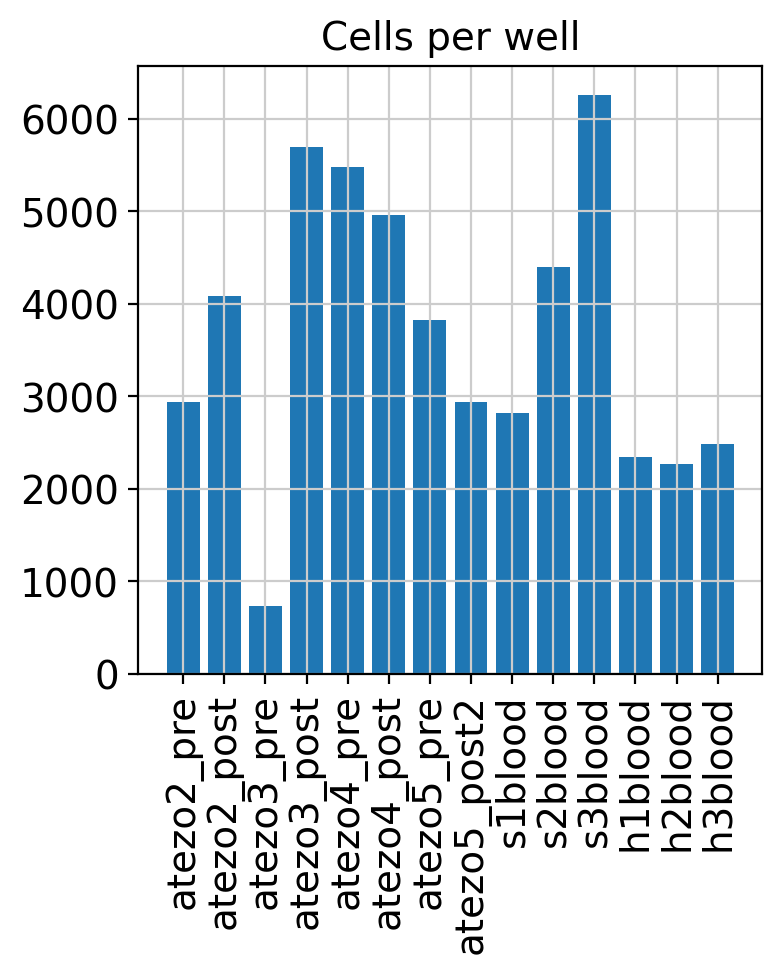

In [27]:
##Plot Cells
height = contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("Cells per well")
    
# Show graphic
plt.show()

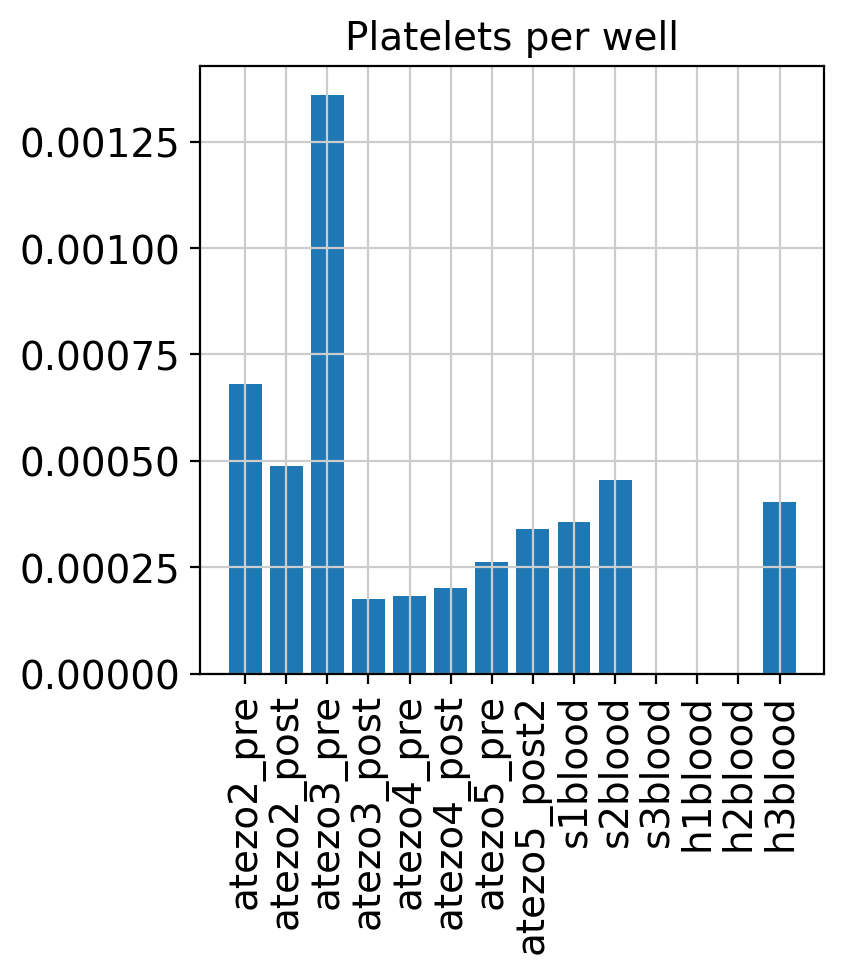

In [28]:
##Plot Platelets

height = contamination_df.iloc[1,:]/contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("Platelets per well")
    
# Show graphic
plt.show()


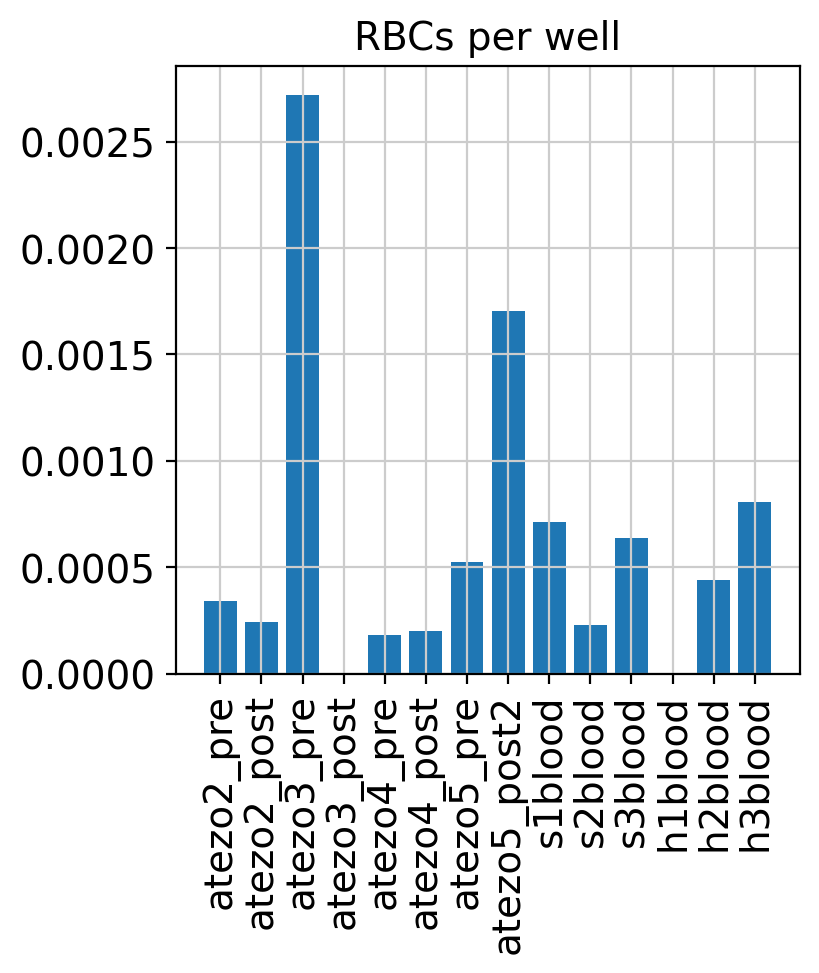

In [29]:
##Plot RBCs

height = contamination_df.iloc[2,:]/contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("RBCs per well")
    
# Show graphic
plt.show()

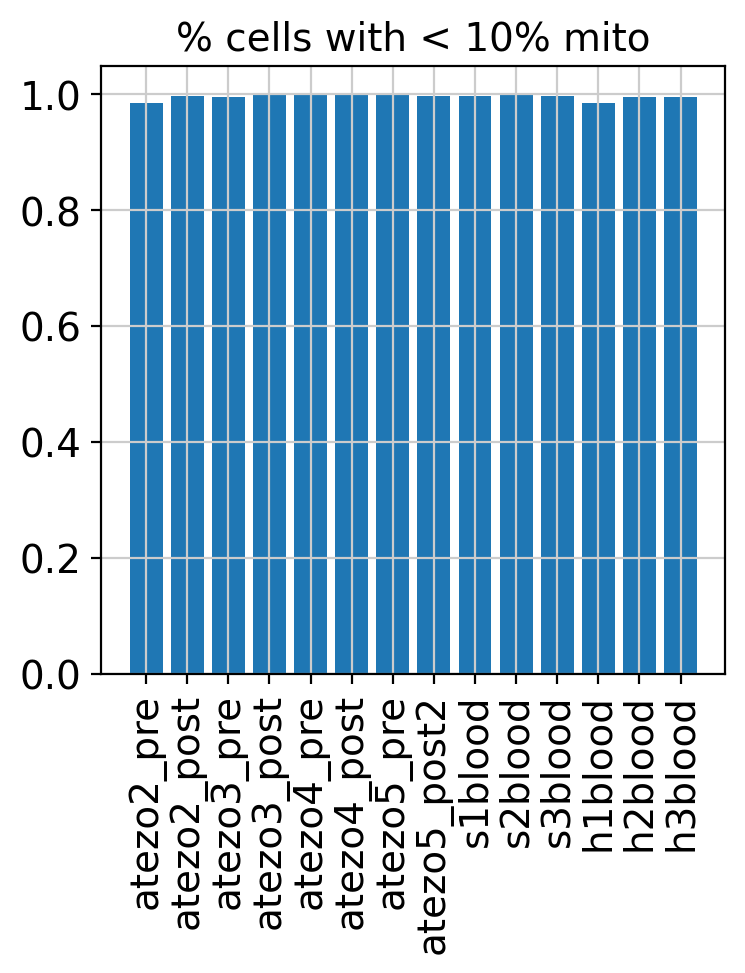

In [30]:
##Plot % mito
height = contamination_df.iloc[3,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("% cells with < 10% mito")
    
# Show graphic
plt.show()

In [31]:
path = '/wynton/group/fong/hyang7/bladder_blood_analysis/obj/preprocessing/'

adata_files = sample
adata_files = [x+"_CD8blood" for x in adata_files]

adata_files = [path + x + '.h5ad' for x in adata_files]

for index in range(len(RNA_adata)):
    RNA_adata[index].write(adata_files[index])

In [33]:
RNA_adata
len(RNA_adata)

14